In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
'''
Итоговые задания для меня:
    + перенести весь необходимый для запуска семинара код dlnlputils (с учетом моих ранее проиизведенных модификаций)
    + проанализировать и понять код семинара (если нужно, добавить развернутые комментарии), в особенности понять 
      изменения, которые позволяют учитывать слова не только слева, но и справа
    + разобраться с приведенным в .../Samsung-IT-Academy/stepik-dl-nlp/blob/master/task7.1_aspect_sentiment_eval.ipynb 
      решением для обработки незнакомых слов, реализовать предложенные изменения
    + понять в чем существенная разница (4-5%) в Accuracy между baseline и baseline_7.1
        Выявленная разница:
            = +2-3% Accuracy дает преобразование токенов в lowercase (для сравнения, словарь без lowercase = 11333, 
              с lowercase = 10362)
            = разные подходы к взвешиванию классов, которое применяется в loss (подробнее в примечаниях ниже)
    + добавить свой пример с незнакомыми словами, посмотреть как отрабатывают модели, в том числе добиться исключения 
      (обработанного чере try на baseline)
    + разобраться с другими (из предложенных в задании выше) решениями по обработке незнакомых слов
        + Помимо замороженного embedding слоя сделать тренируемый embedding слой, состоящий из вектора <unknown>> 
          (Интересный трюк, возможную имплементацию можно посмотреть здесь:
          https://stackoverflow.com/questions/54924582/is-it-possible-to-freeze-only-certain-embedding-weights-in-the-embedding-layer-i )
          В статье 2 варианта реализации:
              = 1. Divide embeddings into two separate objects (реализацию разобрал, все понятно)
              = 2. Zero gradients for specified tokens (реализацию разобрал, все понятно)
        + (не представляет интереса с точки реализации, в сравнении с предыдущим решением, итог -> не требует доп. разбора) Для незнакомых 
          слов добавить тэг <unknown> и задать для него случайный вектор в embedding слое; Сделать embedding слой обучаемым
    + добавить дополнительную метрику для сравнения моделей - Accuracy без учета тегов Other (в реальных данных)
    - улучшить результаты достигаемые предложенным baseline_7.1, проверить гипотезы:
        - эксперименты с весами лосс функции (убрать взвешивание, изменить взвешивание)
        + брать модель с максимальным фссгкфсн, а не просто последнюю модель после фиксированного числа эпох (как в baseline)
        - вариации HIDDEN_DIM (в baseline 32), попробовать 64 и 128
        - optimizer попробовать Adam c 0.01
        - lr 0.01
        - вместо LSTM попробовать GRE
        - проверить num_layers = 3 при dropout = 0 и 0.2


Дополнительные примечания, полученные в ходе работы над семинаром:
 - нужно отметить, что по факту, здесь реализован только aspect анализ, сентимент (тональность, т.е. негативный/позитивный 
   отзыв) анализ показан вначале, в том виде, как он выглядит в разметке, но ему модель не обучают
 - на заметку, что используемая модель FastText дает возможность получать вектора эмбеддингов для любого выдуманного токена
 - существенно влияет на Accuracy взвешивание моделей, например, baseline_7.1 выигрывает у baseline на 4-5% за счет того,
   что взвешивание классов (для loss), происходит по разному (upd. при дальнейшем анализе, когда я создал дополнительную метрику, 
   Accuracy без учета класса Other, она наоборот выше, при типе взвешивания baseline, т.е. когда мы существенно занижаем 
   с помощью весов, самый огромный дисбалансный класс Other); более подробно про типы взвешиваний:
       - baseline количество отнесений к классу считается просто через подсчет общего количетва тегов, использумых в датасете
         (например, если тег 'Other' проставлен для слова 'aa' 3 раза, для слова 'bb' 2 раза, по итогу считаем как 5 отнесений)
       - baseline_7.1 количество отнесений к классу считается на основе количества уникальных токенов, которым проставлен тег 
         в датасете (например, если тег 'Other' проставлен для слова 'aa' 3 раза, для слова 'bb' 2 раза, по итогу = 2 отнесения)
    как итог, разбалансированность при подсчете baseline_7.1 (и как следствие корректировки весов) получется значительно ниже,
    чем в baseline и это сказывается положительно на итоговом Accuracy. В целом, замечаю, что если дисбаланс огромный, и веса
    править соответсвующим образом, это негативно сказывается, в сравнении с тем, когда веса правятся более сглажено (способов
    много, логарифмирование, либо подход как здесь, либо что-то еще)
 - очень интересно, что здесь мы не используем совсем батч, как следствие, мы можем подавать на вход сети предложение (turple bp
   токенов) любой длины, в процессе обучения, мы так же не выравниваем предложения по длине, а просто передаем как есть


P.S. C учетом быстро пройденного предыдущего семинара, могу спокойно отвести на этот семинар неделю, спешить не стоит.
''';

In [3]:
# Для выполнения этого задания не забудьте установить:
#!pip3 install spacy_udpipe
!pip3 install ipymarkup
!pip3 install livelossplot
!pip3 install wget

!pip3 uninstall gensim -y
!pip3 uninstall scattertext -y
!pip3 install gensim==3.8.3

  Preparing metadata (setup.py) ... - done
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=1f01d4d515937a334aebf8f7f4920f16b09e75348d09c511c4e4fa12e080776b
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=c2431846dbfc901de05b2f93a7623ba27842fb365e241c1653eac4b736818dd2
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Found existing installation: gensim 4.0.1
Uninstalling gensim-4.0.1:
  Successfully uninstalled gensim-4.0.1
Found existing installation: scattertext 0.1.5
Uninstalling scattertext-0.1.5:
  Successfully uninstalled scattertext-0.1.5
     |████████████████████████████████| 24.2 MB 406 kB/s            


### Код из библиотеки dlnlputils репозитория https://github.com/Samsung-IT-Academy/stepik-dl-nlp

In [4]:
# stepik-dl-nlp/dlnlputils/data/base.py#########

import collections
import re

import numpy as np

TOKEN_RE = re.compile(r'[\w\d]+')


def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]

def character_tokenize(txt):
    return list(txt)

def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

def tokenize_corpus_verbose(texts, tokenizer=tokenize_text_simple_regex, verbose_chunk=1000, **tokenizer_kwargs):
    tokenize_texts = []
    for i, text in enumerate(texts):
        tokenize_texts.append(tokenizer(text, **tokenizer_kwargs))
        if i % verbose_chunk == 0:
            print('Complete: {}/{}'.format(i,len(texts)))
    return tokenize_texts

def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]


def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None, start_end_tag = False):
    #modified add start/end tags of words
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])
    
    # добавим теги начала и конца слова, для задачи POS-tagging
    if start_end_tag and pad_word is not None:
        sorted_word_counts = [('<START>', 1)] + [('<END>', 2)] + sorted_word_counts
    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


#########stepik-dl-nlp/dlnlputils/data/bag_of_words.py#########

import numpy as np
import scipy.sparse
import torch
from torch.utils.data import Dataset


def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    #modified by me 
    #add 'lftidf', 'tflidf', 'ltflidf', 'ltf', 'lidf'
    
    assert mode in {'tfidf', 'idf', 'tf', 'bin', 'ltfidf', 'tflidf', 'tflidf_v2', 'ltf', 'tfpmi'}

    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слова в документе
    elif mode == 'tf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))

    # полностью убираем информацию о количестве употреблений слова в данном документе,
    # но оставляем информацию о частотности слова в корпусе в целом
    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(1 / word2freq)

    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(1 / word2freq)  # разделить каждый столбец на вес слова

    elif mode == 'ltf': # lTF=ln⁡(TF+1)
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))
        result = scipy.sparse.dok_matrix(np.log(result.toarray()+1))
 
    elif mode == 'lidf': # lIDF=ln⁡(n/IDF+1)
        result = (result > 0).astype('float32').multiply(len(tokenized_texts) / word2freq)
        result = scipy.sparse.dok_matrix(np.log(result.toarray()+1))

        
    elif mode == 'ltfidf': # lTFIDF=ln⁡(TF+1)⋅IDF
        result = result.tocsr() #переводим матрицу в режим быстрой работы со строками (это очень важно!!)
        result = result.multiply(1/result.sum(1)) # разделить каждую строку на её длину
        result = scipy.sparse.dok_matrix(np.log(result.toarray()+1))
        result = result.multiply(1 / word2freq) # разделить каждый столбец на вес слова
        

    elif mode == 'tflidf': # lTFIDF=TF⋅ln⁡(1/IDF+1)
        result = result.tocsr() #переводим матрицу в режим быстрой работы со строками (это очень важно!!)
        result = result.multiply(1/result.sum(1)) # разделить каждую строку на её длину
        result = result.multiply(np.log(1 / word2freq + 1)) # разделить каждый столбец на вес слова

    elif mode == 'tflidf_v2': # lTFIDF=TF⋅ln⁡(n/IDF+1)
        result = result.tocsr() #переводим матрицу в режим быстрой работы со строками (это очень важно!!)
        result = result.multiply(1/result.sum(1)) # разделить каждую строку на её длину
        result = result.multiply(np.log(len(tokenized_texts) / word2freq + 1)) # разделить каждый столбец на вес слова
        
    elif mode == 'tfpmi': # TFPMI=TF⋅PMI
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(word2freq)  # домножить каждую строку на word2freq (это массив PMI Scores)

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()


class SparseFeaturesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        cur_features = torch.from_numpy(self.features[idx].toarray()[0]).float()
        cur_label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        return cur_features, cur_label
    
    
#########stepik-dl-nlp/dlnlputils/pipeline.py#########

import copy
import datetime
import random
import traceback

import numpy as np
import torch
from torch.utils.data import DataLoader


def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True


def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))


def print_grad_stats(model):
    mean = 0
    std = 0
    norm = 1e-5
    for param in model.parameters():
        grad = getattr(param, 'grad', None)
        if grad is not None:
            mean += grad.data.abs().mean()
            std += grad.data.std()
            norm += 1
    mean /= norm
    std /= norm
    print(f'Mean grad {mean}, std {std}, n {norm}')


def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0,
                    best_acc_type = 'loss',
                    test_dataset = None,
                    experiment_name = 'NoName',
                    no_calculate_accuracy = False):
    """
    v2.3
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    
    '''
    modified by wisoffe
    best_acc_type: 'loss' or 'acc'
    experiment_name: 
    '''
    assert best_acc_type in {'loss', 'acc'}
    
    train_start_time = datetime.datetime.now()
    print("############## Start experiment with name: {} ##############".format(experiment_name))
    
    #statistics history
    history = {'acc': {'train': [0.0],
                       'val': [0.0]},
               'loss': {'train': [float('inf')],
                       'val': [float('inf')]}}
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)
    
    if best_acc_type == 'loss': #отбираем модель по минимальному loss
        best_val_metric = float('inf')
    elif best_acc_type == 'acc': #отбираем модель по максимальному accuracy
        best_val_metric = float('-inf')
        
    best_epoch_i = 0
    best_model = copy.deepcopy(model)
    
    
    for epoch_i in range(1, epoch_n + 1):
        try:
            #####train phase######
            epoch_start = datetime.datetime.now()
            train_accuracy_epoch = [] #for statistics
            train_loss_epoch = [] #for statistics
            
            model.train()
            
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    print('Threshold max_batches_per_epoch_train exceeded!')
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                train_loss_epoch.append(float(loss))
                
                if not no_calculate_accuracy:
                    train_accuracy_epoch.append(float((pred.argmax(dim=1) == batch_y.data).float().mean().data))
                    #train_accuracy_epoch.append(float((pred.detach().cpu().numpy().argmax(-1) == batch_y.detach().cpu().numpy()).mean()))
                else: train_accuracy_epoch.append(0.)
                    
            train_iters = batch_i
            #####validation phase######
            model.eval()

            val_accuracy_epoch = [] #for statistics
            val_loss_epoch = [] #for statistics

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        print('Threshold max_batches_per_epoch_val exceeded!')
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)
                    
                    if not no_calculate_accuracy:
                        val_accuracy_epoch.append(float((pred.argmax(dim=1) == batch_y.data).float().mean().data))
                        #val_accuracy_epoch.append(float((pred.detach().cpu().numpy().argmax(-1) == batch_y.detach().cpu().numpy()).mean()))
                    else:
                        val_accuracy_epoch.append(0.)
                    val_loss_epoch.append(float(loss))

            
            ########ending of epoch#########
            
            history['acc']['train'].append(sum(train_accuracy_epoch) / len(train_accuracy_epoch))
            history['loss']['train'].append(sum(train_loss_epoch) / len(train_loss_epoch))  

            history['acc']['val'].append(sum(val_accuracy_epoch) / len(val_accuracy_epoch))
            history['loss']['val'].append(sum(val_loss_epoch) / len(val_loss_epoch))
            
            
            #save best model
            best_model_saved = False
            if (best_acc_type == 'loss' and history['loss']['val'][-1] < best_val_metric) or \
                    (best_acc_type == 'acc' and history['acc']['val'][-1] > best_val_metric):
                #отбираем модель по минимальному loss или максимальному accuracy
                best_epoch_i = epoch_i
                best_val_metric = history[best_acc_type]['val'][-1]
                best_model = copy.deepcopy(model)
                best_model_saved = True
            #check for break training
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(history['loss']['val'][-1])
            
            #output statistics
            
            print('Epoch = {:>3},   ACC: val = {:.4f}, train = {:.4f}    LOSS: val = {:.4f}, train = {:.4f}   SAVE: {}, Iters: {}, Time: {:0.2f}s'\
                  .format(epoch_i,
                          history['acc']['val'][-1], 
                          history['acc']['train'][-1],
                          history['loss']['val'][-1],
                          history['loss']['train'][-1],
                          best_model_saved,
                          train_iters,
                          (datetime.datetime.now() - epoch_start).total_seconds()),
                  flush=True)

        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break
            
    print(' ')
    print("BEST MODEL: ACC: val = {:.4f}, train = {:.4f}, LOSS: val = {:.4f}, train = {:.4f}, on epoch = {}, metric type = {}, Full train time = {:0.2f}s"\
                  .format(history['acc']['val'][best_epoch_i], 
                          history['acc']['train'][best_epoch_i],
                          history['loss']['val'][best_epoch_i],
                          history['loss']['train'][best_epoch_i],
                          best_epoch_i,
                          best_acc_type,
                          (datetime.datetime.now() - train_start_time).total_seconds()))
    print("************** End experiment with name: {} **************".format(experiment_name))
    print(' ')
    history['BEST'] = {}
    history['BEST']['epoch'] = best_epoch_i
    history['BEST']['dict_size'] = batch_x.shape[-1]
    
    
    #calculate and save final metrics best_model on train/val/test datasets
    if test_dataset is not None:
        history['BEST']['acc'] = {}
        history['BEST']['loss'] = {}
        
        #save validation metrics (no calculate again)
        history['BEST']['acc']['val'] = history['acc']['val'][best_epoch_i]
        history['BEST']['loss']['val'] = history['loss']['val'][best_epoch_i]
        
        #calculate and save train metrics
        train_pred = predict_with_model(best_model, train_dataset, return_labels=True)
        history['BEST']['loss']['train'] = float(F.cross_entropy(torch.from_numpy(train_pred[0]),
                             torch.from_numpy(train_pred[1]).long()))
        history['BEST']['acc']['train'] = accuracy_score(train_pred[1], train_pred[0].argmax(-1))
        
        #calculate and save test metrics
        test_pred = predict_with_model(best_model, test_dataset, return_labels=True)
        history['BEST']['loss']['test'] = float(F.cross_entropy(torch.from_numpy(test_pred[0]),
                             torch.from_numpy(test_pred[1]).long()))
        history['BEST']['acc']['test'] = accuracy_score(test_pred[1], test_pred[0].argmax(-1))    
    
    best_model.eval()
    
    return history, best_model


def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        import tqdm
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)


#########stepik-dl-nlp/dlnlputils/nnets.py#########

from torch.utils.data import Dataset


def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt


class PaddedSequenceDataset(Dataset):
    def __init__(self, texts, targets, out_len=100, pad_value=0):
        self.texts = texts
        self.targets = targets
        self.out_len = out_len
        self.pad_value = pad_value

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        txt = self.texts[item]

        txt = ensure_length(txt, self.out_len, self.pad_value)
        txt = torch.tensor(txt, dtype=torch.long)

        target = torch.tensor(self.targets[item], dtype=torch.long)

        return txt, target

    
def make_mask_from_lengths(lengths, max_length):
    result = torch.zeros(len(lengths), max_length, dtype=torch.bool)
    for sample_i, cur_len in enumerate(lengths):
        result[sample_i, :cur_len] = 1
    return result

#########stepik-dl-nlp/dlnlputils/embeddings.py#########

class Embeddings:
    def __init__(self, embeddings, word2id):
        self.embeddings = embeddings
        self.embeddings /= (np.linalg.norm(self.embeddings, ord=2, axis=-1, keepdims=True) + 1e-4)
        self.word2id = word2id
        self.id2word = {i: w for w, i in word2id.items()}

    def most_similar(self, positive=None, negative=None, topk=10, with_mean = False):
        #modified by wis, converted to gensim syntax
        
        if positive is not None:
            if type(positive) != list:
                positive = [positive]
            pos_vec = [self.get_vector(word) for word in positive]
            pos_len = len(positive)
        else:
            pos_vec = 0
            pos_len = 1
            
        if negative is not None:
            if type(negative) != list:
                negative = [negative]
            neg_vec = [self.get_vector(word) for word in negative]
            neg_len = len(negative)
        else:
            neg_vec = 0
            neg_len = 1
        
        if with_mean:
            result_vec = np.array(pos_vec).sum(0) / pos_len - np.array(neg_vec).sum(0) / neg_len
        else:
            result_vec = np.array(pos_vec).sum(0) - np.array(neg_vec).sum(0)
        
        return self.most_similar_by_vector(result_vec, topk=topk)
    
    def most_similar_legacy(self, word, topk=10):
        return self.most_similar_by_vector(self.get_vector(word), topk=topk)

    def analogy(self, a1, b1, a2, topk=10):
        a1_v = self.get_vector(a1)
        b1_v = self.get_vector(b1)
        a2_v = self.get_vector(a2)
        query = b1_v - a1_v + a2_v
        return self.most_similar_by_vector(query, topk=topk)

    def most_similar_by_vector(self, query_vector, topk=10):
        similarities = (self.embeddings * query_vector).sum(-1)
        best_indices = np.argpartition(-similarities, topk, axis=0)[:topk]
        result = [(self.id2word[i], similarities[i]) for i in best_indices]
        result.sort(key=lambda pair: -pair[1])
        return result

    def get_vector(self, word):
        if word not in self.word2id:
            raise ValueError('Неизвестное слово "{}"'.format(word))
        return self.embeddings[self.word2id[word]]

    def get_vectors(self, *words):
        word_ids = [self.word2id[i] for i in words]
        vectors = np.stack([self.embeddings[i] for i in word_ids], axis=0)
        return vectors

#########stepik-dl-nlp/dlnlputils/visualization.py#########

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE


def plot_vectors(vectors, labels, how='tsne', ax=None, xy_lim=None):
    if how == 'tsne':
        projections = TSNE().fit_transform(vectors)
    elif how == 'svd':
        projections = TruncatedSVD().fit_transform(vectors)

    x = projections[:, 0]
    y = projections[:, 1]
    if xy_lim is not None:
        ax.set_xlim(xy_lim)
        ax.set_ylim(xy_lim)
    ax.scatter(x, y)
    for cur_x, cur_y, cur_label in zip(x, y, labels):
        ax.annotate(cur_label, (cur_x, cur_y))
        

#########stepik-dl-nlp/dlnlputils/data/pos.py#########
import torch
from torch.utils.data import TensorDataset

def pos_corpus_to_tensor(sentences, char2id, label2id, max_sent_len, max_token_len):
    #v1.2 add custom start/end tag functionaly
    inputs = torch.zeros((len(sentences), max_sent_len, max_token_len + 2), dtype=torch.long)
    inputs[:,:,0] = char2id.get('<START>', 0)
    targets = torch.zeros((len(sentences), max_sent_len), dtype=torch.long)

    for sent_i, sent in enumerate(sentences):
        for token_i, token in enumerate(sent):
            targets[sent_i, token_i] = label2id.get(token.upos, 0)
            if token.form is not None:
                for char_i, char in enumerate(token.form):
                    inputs[sent_i, token_i, char_i + 1] = char2id.get(char, 0)
            else:
                for char_i, char in enumerate('-'):
                    inputs[sent_i, token_i, char_i + 1] = char2id.get(char, 0)
            inputs[sent_i, token_i, char_i + 2] = char2id.get('<END>', 0)

    return inputs, targets


class POSTagger:
    def __init__(self, model, char2id, id2label, max_sent_len, max_token_len):
        self.model = model
        self.char2id = char2id
        self.id2label = id2label
        self.max_sent_len = max_sent_len
        self.max_token_len = max_token_len

    def __call__(self, sentences):
        tokenized_corpus = tokenize_corpus(sentences, min_token_size=1)

        inputs = torch.zeros((len(sentences), self.max_sent_len, self.max_token_len + 2), dtype=torch.long)
        inputs[:,:,0] = self.char2id.get('<START>', 0)

        for sent_i, sentence in enumerate(tokenized_corpus):
            for token_i, token in enumerate(sentence):
                for char_i, char in enumerate(token):
                    inputs[sent_i, token_i, char_i + 1] = self.char2id.get(char, 0)
                inputs[sent_i, token_i, char_i + 2] = self.char2id.get('<END>', 0)

        dataset = TensorDataset(inputs, torch.zeros(len(sentences)))
        predicted_probs = predict_with_model(self.model, dataset)  # SentenceN x TagsN x MaxSentLen
        predicted_classes = predicted_probs.argmax(1)

        result = []
        for sent_i, sent in enumerate(tokenized_corpus):
            result.append([self.id2label[cls] for cls in predicted_classes[sent_i, :len(sent)]])
        return result


#########stepik-dl-nlp/dlnlputils/data/poetry.py#########

import heapq
import random

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset


def load_war_and_piece_chunks(fname, chunk_size=200):
    #v1.1 fix bugs by wisoffe
    with open(fname, 'r') as fin:
        full_text = fin.read()
    return [full_text[start:start + chunk_size] for start in range(0, len(full_text) - chunk_size, chunk_size // 2)]


def save_texts_to_file(texts, out_file):
    with open(out_file, 'w') as outf:
        outf.write('\n'.join(texts))


class LanguageModelDataset(Dataset):
    def __init__(self, token_ids, chunk_length=100, pad_value=0):
        self.token_ids = token_ids
        self.chunk_length = chunk_length
        self.pad_value = pad_value

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, item):
        text = self.token_ids[item]
        start_i = random.randint(0, max(0, len(text) - self.chunk_length - 1))
        chunk = text[start_i : start_i + self.chunk_length + 1]

        seed_part = chunk[:-1]
        target_part = chunk[1:]
        
        #ensure_length(txt, out_len, pad_value) - на основе txt возвращает последовательность длины 
        #out_len, если длина txt > out_len, обрезает, если txt < out_len добивает ее символами pad_value
        seed_part = ensure_length(seed_part, self.chunk_length, self.pad_value)
        target_part = ensure_length(target_part, self.chunk_length, self.pad_value)

        seed_part = np.array(seed_part)
        target_part = np.array(target_part)

        return seed_part, target_part


class GreedyGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40):
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        
        #начиная с заданной последовательности, через цикл (либо выполняем max_steps_n итераций, 
        #либо при достижении токена eos_token_id), на каждой итерации передаем в модель текущую 
        #накопленную последовательность с целью генерации logits следующего токена, далее выбираем 
        #через [0, -1].argmax() самый вероятный токен, добавляем его к нашей последовательности
        #Важно отметить, что по факту при передачи последовательности, происходит вычисление
        #logits, для каждой позиции переданной последовательности, что является ненужной 
        #вычислительной нагрузкой, но в данном случае на это не заморачивается, с целью упрощения
        #кода (при этом в рабочей/продакшн системе подобное недопустимо)
        for _ in range(max_steps_n):
            in_batch = torch.tensor(seed_tokens).unsqueeze(0).to(self.device)
            best_next_token = self.model(in_batch)[0, -1].argmax()
            if best_next_token == self.eos_token_id:
                break

            seed_tokens.append(best_next_token)

        return self.tokenizer.decode([seed_tokens])[0]


class BeamGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40, return_hypotheses_n=5, beamsize=5):
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        initial_length = len(seed_tokens)

        #кортежи из:
        # - score последовательности, положительный, чем меньше, тем лучше
        #   (т.е. последовательность более правдоподобна/вероятна)
        # - сама последовательность из token ids
        partial_hypotheses = [(0, seed_tokens)]
        final_hypotheses = []
        
        #heapq - алгоритм двоичной кучи (упорядоченное дерево), в которой родитель всегда <= детей
        while len(partial_hypotheses) > 0:
            #возвращаем, удалив, из списка кортежей самый первый (наименьший=наилучший по скору) элемент,
            #в скор (положительный, чем меньше, тем лучше) и саму последовательность (token ids) 
            cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)
            
            #получаем предсказания в виде log-вероятностей для каждого токена из словаря,
            #быть на следующем месте после заданной последовательности cur_partial_hypothesis
            #важные примечания:
            # - логарифмирование вероятностей производится по причине того, что здесь необходимо 
            #   считать вероятность длинных последовательностей, а именно произведения вероятностей, 
            #   если их не логарифмировать, то порядок итоговой вероятности будет очень быстро уменьшатся
            #   мы бытро столкнемся с практически нулевыми вероятностями, а во в случае логарифмирования, 
            #   log произведения вероятностей = сумме логарифмов этих вероятностей, как следствие, 
            #   мы будем работать уже с порядками итоговой вероятности, и не столкнемся с занулением
            # - log-вероятностей это отрицательные числа, но упорядоченность и направление сохраняются,
            #   т.е. чем больше изначальная вероятность, тем больше и log-вероятности
            in_batch = torch.tensor(cur_partial_hypothesis).unsqueeze(0).to(self.device)
            next_tokens_logits = self.model(in_batch)[0, -1]
            next_tokens_logproba = F.log_softmax(next_tokens_logits)
            #.topk возвращает структуру из values и indices, в которых находятся тензоры,
            #содержащие в себе указанное кол-во максимальных значений (log вероятностей) и их индексов
            topk_continuations = next_tokens_logproba.topk(beamsize)
            
            #итерируемся по .topk log-вероятностям токенов и их индексам (=ids)
            for token_logproba, token_idx in zip(topk_continuations.values, topk_continuations.indices):
                #преобразовываем из тензоров в чистые значения
                token_logproba = float(token_logproba)
                token_idx = int(token_idx)
                
                #здесь используется подход по нормализации итоговых logit через деление на корень из 
                #длины самой последовательности, что бы более короткие последовательности не имели 
                #несравнимо большие logits, чем длинные последовательности; т.к. логиты отрицательны, 
                #то при делении на бОльшее число (>1), мы получим относительное увеличение итогового 
                #логита
                #например: у нас есть 2 последовательности длиной 4 и 9 символов, если их 
                #ненормированные логиты = -10, то после нормальзации на корень длины, они будут
                #равны -10/2=-5 и -10/3=-3.333, в итоге более длинная последовательность "выиграет"
                #
                #денормализуем и сохраняем исходный score последовательности, 
                old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hypothesis))
                
                #token_logproba - это log-вероятности (т.е. отрицательное число, причем чем больше, тем 
                #правдоподеобней/вероятней последовательность), а нашу кучу мы строим на основе скоров 
                #(т.е. положительных, нормированных величин, чем меньше, тем лучше), здесь преобразовываем 
                #одно в другое (именно поэтому мы отнимаем, а не прибавляем token_logproba)
                new_score = (old_denorm_score - token_logproba) / np.sqrt(len(cur_partial_hypothesis) + 1)

                new_hypothesis = cur_partial_hypothesis + [token_idx]
                new_item = (new_score, new_hypothesis)
                
                #либо считаем последовательность оконченой, либо пушим в кучу для дальнейших предсказаний
                if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
                    final_hypotheses.append(new_item)
                else:
                    heapq.heappush(partial_hypotheses, new_item)
            
            #при таком подходе мне кажется мы сильно полагаемся на верность нашей нормализации, т.к.
            #т.к. "досрочно" сравниваем наши последовательности разной длины (мощности), более детально
            #проанализировать этот момент, придумать альтернативы
            if len(partial_hypotheses) > beamsize:
                partial_hypotheses = heapq.nsmallest(beamsize, partial_hypotheses)
                heapq.heapify(partial_hypotheses)
        
        #реализовано не слишком эффективно, есть лишние вычисления, особенно когда вариантов на этом этапе
        #значительно больше количества, которое нам нужно вернуть
        #при анализе не забыть учесть, что в начале цикла мы выбираем элемент с наименьшим логитом
        final_scores, final_token_lists = zip(*final_hypotheses)
        final_texts = self.tokenizer.decode(list(final_token_lists))

        result = list(zip(final_scores, final_texts))
        result.sort()
        result = result[:return_hypotheses_n]

        return result

class myBeamGenerator:
    '''
    Моя реализация классического алгоритма лучевого поиска, разница в том, что перед тем, как оставить 
    топ beamsize гипотез, мы сначала делаем по одному шагу для всех существующих гипотез (т.е. сравниваем
    мы гипотезы и выбираем из них топ, только когда количество токенов в них одинаково)
    
    '''
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40, return_hypotheses_n=5, beamsize=5, norm='sqrt_len'):
        assert norm in {'sqrt_len', 'len', 'nonorm'}
        
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        initial_length = len(seed_tokens)

        #кортежи из:
        # - score последовательности, положительный, чем меньше, тем лучше
        #   (т.е. последовательность более правдоподобна/вероятна)
        # - сама последовательность из token ids
        partial_hypotheses = [(0, seed_tokens)]
        next_step_hypotheses = []
        final_hypotheses = []
        
        #heapq - алгоритм двоичной кучи (упорядоченное дерево), в которой родитель всегда <= детей
        while len(partial_hypotheses) > 0:
            #возвращаем, удалив, из списка кортежей самый первый (наименьший=наилучший по скору) элемент,
            #в скор (положительный, чем меньше, тем лучше) и саму последовательность (token ids) 
            cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)
            
            #получаем предсказания в виде log-вероятностей для каждого токена из словаря,
            #быть на следующем месте после заданной последовательности cur_partial_hypothesis
            #важные примечания:
            # - логарифмирование вероятностей производится по причине того, что здесь необходимо 
            #   считать вероятность длинных последовательностей, а именно произведения вероятностей, 
            #   если их не логарифмировать, то порядок итоговой вероятности будет очень быстро уменьшатся
            #   мы бытро столкнемся с практически нулевыми вероятностями, а во в случае логарифмирования, 
            #   log произведения вероятностей = сумме логарифмов этих вероятностей, как следствие, 
            #   мы будем работать уже с порядками итоговой вероятности, и не столкнемся с занулением
            # - log-вероятностей это отрицательные числа, но упорядоченность и направление сохраняются,
            #   т.е. чем больше изначальная вероятность, тем больше и log-вероятности
            in_batch = torch.tensor(cur_partial_hypothesis).unsqueeze(0).to(self.device)
            next_tokens_logits = self.model(in_batch)[0, -1]
            next_tokens_logproba = F.log_softmax(next_tokens_logits)
            #.topk возвращает структуру из values и indices, в которых находятся тензоры,
            #содержащие в себе указанное кол-во максимальных значений (log вероятностей) и их индексов
            topk_continuations = next_tokens_logproba.topk(beamsize)
            
            #итерируемся по .topk log-вероятностям токенов и их индексам (=ids)
            for token_logproba, token_idx in zip(topk_continuations.values, topk_continuations.indices):
                #преобразовываем из тензоров в чистые значения
                token_logproba = float(token_logproba)
                token_idx = int(token_idx)
                
                #выбираем нормализацию
                if norm == 'sqrt_len':
                    old_norm_value = np.sqrt(len(cur_partial_hypothesis))
                    new_norm_value = np.sqrt(len(cur_partial_hypothesis) + 1)
                elif norm == 'len':
                    old_norm_value = len(cur_partial_hypothesis)
                    new_norm_value = len(cur_partial_hypothesis) + 1
                elif norm == 'nonorm':
                    old_norm_value = 1
                    new_norm_value = 1
                
                #здесь используется подход по нормализации итоговых logit через деление на корень из 
                #длины самой последовательности, что бы более короткие последовательности не имели 
                #несравнимо большие logits, чем длинные последовательности; т.к. логиты отрицательны, 
                #то при делении на бОльшее число (>1), мы получим относительное увеличение итогового 
                #логита
                #например: у нас есть 2 последовательности длиной 4 и 9 символов, если их 
                #ненормированные логиты = -10, то после нормальзации на корень длины, они будут
                #равны -10/2=-5 и -10/3=-3.333, в итоге более длинная последовательность "выиграет"
                #
                #денормализуем и сохраняем исходный score последовательности, 
                old_denorm_score = cur_partial_score * old_norm_value
                
                #token_logproba - это log-вероятности (т.е. отрицательное число, причем чем больше, тем 
                #правдоподеобней/вероятней последовательность), а нашу кучу мы строим на основе скоров 
                #(т.е. положительных, нормированных величин, чем меньше, тем лучше), здесь преобразовываем 
                #одно в другое (именно поэтому мы отнимаем, а не прибавляем token_logproba)
                new_score = (old_denorm_score - token_logproba) / new_norm_value

                new_hypothesis = cur_partial_hypothesis + [token_idx]
                new_item = (new_score, new_hypothesis)
                
                #либо считаем последовательность оконченой, либо пушим в кучу для дальнейших предсказаний
                if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
                    final_hypotheses.append(new_item)
                else:
                    heapq.heappush(next_step_hypotheses, new_item)
                    
            
            if len(partial_hypotheses) == 0 and len(next_step_hypotheses) > 0:
                partial_hypotheses = heapq.nsmallest(beamsize, next_step_hypotheses)
                heapq.heapify(partial_hypotheses)
                next_step_hypotheses = []
        
        #реализовано не слишком эффективно, есть лишние вычисления, особенно когда вариантов на этом этапе
        #значительно больше количества, которое нам нужно вернуть
        final_scores, final_token_lists = zip(*final_hypotheses)
        final_texts = self.tokenizer.decode(list(final_token_lists))

        result = list(zip(final_scores, final_texts))
        result.sort()
        result = result[:return_hypotheses_n]

        return result

    
#########stepik-dl-nlp/dlnlputils/base.py#########

def get_params_number(model):
    return sum(t.numel() for t in model.parameters())

#########stepik-dl-nlp/dlnlputils/recipe_utils.py#########

import numpy as np
import matplotlib.pyplot as plt

from ipymarkup         import show_box_markup
from ipymarkup.palette import palette, PALETTE, BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

import torch
from collections import Counter

PALETTE.set('NAME', BLUE)
PALETTE.set('UNIT', RED)
PALETTE.set('QTY', GREEN)
PALETTE.set('RANGE_END', GREEN)
PALETTE.set('INDEX', PURPLE)
PALETTE.set('COMMENT', ORANGE)
PALETTE.set('OTHER', BROWN)


def show_markup(recipe,tags):
    mapper = lambda tag: tag[2:] if tag!='OTHER' else tag
    
    tags  = [mapper(tag) for tag in tags]
    text  = ' '.join(recipe)
    spans = []
        
    start,end,tag = 0,len(recipe[0]),tags[0]
    
    for word, ttag in zip(recipe[1:], tags[1:]): 
        
        if tag == ttag:
            end  += 1+len(word)
            
        else:
            span  = (start, end, tag)
            spans.append(span)
        
            start = 1+end
            end  += 1+len(word)
            tag   = ttag
            
    span  = (start, end, tag)
    spans.append(span)        
            
    show_box_markup(text, spans, palette=PALETTE)
    
    
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре
    
    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags
    
    
def tag_statistics(model, converter, data):

    def tag_counter(predicted, ground):
        correct_tags = Counter()
        ground_tags  = Counter(ground)
        
        for tag_p, tag_g in zip(predicted, ground):
            if tag_p==tag_g:
                correct_tags[tag_g]+=1            
        return correct_tags, ground_tags
    
    
    total_correct, total_tags = Counter(), Counter()
    
    for recipe, tags in data:
        tags_pred              = predict_tags(model, converter, recipe)
        tags_correct, tags_num = tag_counter(tags_pred, tags)

        total_correct.update(tags_correct)
        total_tags.update(tags_num)

    return total_correct, total_tags


def recipe_statistics(model, converter,data, limit=None):
        
    correct_recipes = Counter()
    total_recipes   = len(data)

    for recipe, tags in data:
        tags_pred = predict_tags(model, converter,recipe)
        
        tags_pred = np.array(tags_pred)
        tags      = np.array(tags)
        noneq_num = np.sum(tags_pred != tags)
        
        if limit and noneq_num>limit:
            title = 'рецепты, размеченные с >{} ошибками'.format(limit)
        elif noneq_num==0:
            title = 'рецепты, размеченные без ошибок'
        else:
            title = 'рецепты, размеченные с {} ошибками:'.format(noneq_num)
            
        
        correct_recipes[title]+=1
    
    return correct_recipes, total_recipes


def plot_recipe_statistics(correct_recipes, total_recipes=None):

    plt.rcdefaults()
    fig, ax = plt.subplots()

    descr,performance = zip(*correct_recipes.most_common())
    y_pos             = np.arange(len(descr))
    
    if total_recipes is not None:
        performance = 100 * (np.array(performance) / float(total_recipes))
        
        ax.set_title('% размеченных рецептов')
        ax.set_xlabel('% рецептов')
        
    else:
        ax.set_title('количество размеченных рецептов')
        ax.set_xlabel('количество рецептов')

    ax.barh(y_pos, performance, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(descr)
    ax.invert_yaxis()

    plt.show()


def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
   
    cm     = confusion_matrix(y_true, y_pred, labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im      = ax.imshow(cm, interpolation='nearest', cmap=cmap)
   
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, 
           yticklabels=classes,
           title=title,
           ylabel='Истинный тэг',
           xlabel='Предсказанный тэг')
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax


def form_vocabulary_and_tagset(recipes):
    dictionary = set()
    labels     = set()
    for line in recipes:
        if len(line)>0:
            word, label = line.split('\t')
            dictionary.add(word)
            labels.add(label)
            
    return dictionary,labels


def prepare_data(lines):
    recipes_w_tags = []

    recipe, tags = [],[]
    for line in lines:
        if len(line)>0:
            word, label = line.split('\t')
            recipe.append(word)
            tags.append(label)
        else:
            if len(recipe)>0:
                recipes_w_tags.append((recipe,tags))
            recipe, tags = [],[]

    return recipes_w_tags


class Converter():
    def __init__(self,vocabulary, tags):
        self.idx_to_word = sorted(vocabulary)
        self.idx_to_tag  = sorted(tags)

        self.word_to_idx = {word:idx for idx,word in enumerate(self.idx_to_word)}
        self.tag_to_idx  = { tag:idx for idx,tag  in enumerate(self.idx_to_tag)}
        
    def words_to_index(self, words):
        return torch.tensor([self.word_to_idx[w] for w in words], dtype=torch.long)
    
    def tags_to_index(self, words):
        return torch.tensor([self.tag_to_idx[w] for w in words], dtype=torch.long)
    
    def indices_to_words(self, indices):
        return [self.idx_to_word[i] for i in indices]
    
    def indices_to_tags(self, indices):
        return [self.idx_to_tag[i] for i in indices]
    
    

#########stepik-dl-nlp/dlnlputils/sentiment_utils.py#########

import torch


import lxml
from lxml import etree

from ipymarkup         import show_box_markup
from ipymarkup.palette import palette, PALETTE, BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from collections import Counter

# sentiment
PALETTE.set('negative',RED)
PALETTE.set('B-negative',RED)
PALETTE.set('I-negative',RED)
PALETTE.set('positive',GREEN)
PALETTE.set('B-positive',GREEN)
PALETTE.set('I-positive',GREEN)
PALETTE.set('neutral', ORANGE)
PALETTE.set('B-neutral', ORANGE)
PALETTE.set('I-neutral', ORANGE)
PALETTE.set('other', BROWN)
PALETTE.set('Other', BROWN)


# aspect
PALETTE.set('Comfort',ORANGE)
PALETTE.set('B-Comfort',ORANGE)
PALETTE.set('I-Comfort',ORANGE)
PALETTE.set('Appearance',BLUE)
PALETTE.set('B-Appearance',BLUE)
PALETTE.set('I-Appearance',BLUE)
PALETTE.set('Reliability',GREEN)
PALETTE.set('B-Reliability',GREEN)
PALETTE.set('I-Reliability',GREEN)
PALETTE.set('Safety',PURPLE)
PALETTE.set('B-Safety',PURPLE)
PALETTE.set('I-Safety',PURPLE)
PALETTE.set('Driveability',BLUE)
PALETTE.set('B-Driveability',BLUE)
PALETTE.set('I-Driveability',BLUE)
PALETTE.set('Whole',RED)
PALETTE.set('B-Whole',RED)
PALETTE.set('I-Whole',RED)
PALETTE.set('Costs',RED)
PALETTE.set('B-Costs',RED)
PALETTE.set('I-Costs',RED)


def show_markup(text,spans):         
    show_box_markup(text, spans, palette=PALETTE)
    
    
def generate_markup(tokens,tags):
    mapper = lambda tag: tag[2:] if tag!='Other' else tag
    
    tags  = [mapper(tag) for tag in tags]
    text  = ' '.join(tokens)
    spans = []
        
    start,end,tag = 0,len(tokens[0]),tags[0]
    
    for word, ttag in zip(tokens[1:], tags[1:]): 
        
        if tag == ttag:
            end  += 1+len(word)
            
        else:
            span  = (start, end, tag)
            spans.append(span)
        
            start = 1+end
            end  += 1+len(word)
            tag   = ttag
            
    span  = (start, end, tag)
    spans.append(span)        
            
    return text, spans


# --------- tokenization & sentence detection & BIO-tagging ---------


def fill_gaps(text, source_spans):
    """ Заполняем пробелы в авторской разметке """
    
    chunks = []
    
    text_pos = 0
    for span in source_spans:
        s,e,t = span
        if text_pos<s:
            chunks.append((text_pos,s,'Other'))
        chunks.append((s,e,t))
        text_pos=e
            
    if text_pos<len(text)-1:
        chunks.append((text_pos,len(text),'Other'))
    
    return chunks


def extract_BIO_tagged_tokens(text, source_spans, tokenizer):
    """ Разобьем на bio-токены по безпробельной разметке """
    
    tokens_w_tags = []
    for span in source_spans:
        s,e,tag  = span
        tokens   = tokenizer(text[s:e])
        
        if tag == 'Other':
            tokens_w_tags += [(token,tag) for token in tokens]
        else:
            tokens_w_tags.append((tokens[0],'B-'+tag))
            for token in tokens[1:]:
                tokens_w_tags.append((token,'I-'+tag))
                
    return tokens_w_tags


import re

def regex_sentence_detector(text):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    return sentences

def sentence_spans(text, sentence_detector):
    """ Разбиваем на предложения и генерируем разметку - для красоты """
    
    sentences = sentence_detector(text)

    spans = []
    
    sent_start= 0
    idx       = 1
    for sent in sentences:    
        sent_end = sent_start + len(sent)
        spans.append((sent_start,sent_end, 's{}'.format(idx)))
        
        sent_start = 1+sent_end
        idx       += 1
        
    return spans


def sentence_splitter(text, spans):
    """ Разбиваем на предложения и перегенерируем разметку  """
    result = []
    
    sentences = regex_sentence_detector(text)
    
    sent_start = 0
    span_idx   = 0
    
    for sent in sentences:
        sent_end = sent_start + len(sent)
        
        sent_spans = []
        for span in spans[span_idx:]:
            s,e,t = span
            if e <= sent_end:
                sent_spans.append((s-sent_start,e-sent_start,t))
                span_idx+=1
            else:
                continue
                
        result.append((text[sent_start:sent_end], sent_spans))
        
        sent_start = 1+sent_end

    return result

# --------- tokenization & sentence detection & BIO-tagging ---------
    
    
# ------- SentiRuEval-2015 dataset xml parsing --------------

def get_sentiment_spans(root):
    return get_tag_spans(root,'sentiment')

def get_aspect_spans(root):
    return get_tag_spans(root,'category')

def get_tag_spans(root,tag):
    attributes = root.attrib        
    start = int(attributes['from'])
    end   = int(attributes['to'])
    tag   = attributes[tag]
    span  = (start,end,tag)
    return span


def parse_xml_sentiment(xml_file): return parseXML(xml_file, get_sentiment_spans)
def parse_xml_aspect(xml_file):    return parseXML(xml_file, get_aspect_spans)


def parseXML(xmlFile, span_func):
    xml  = open(xmlFile).read()
    root = etree.fromstring(xml)
    
    result = []
    for review in root.getchildren(): 
        for elem in review.getchildren():            
            if elem.tag == 'text':
                text  = elem.text
            if elem.tag == 'aspects':
                spans = [span_func(xml_span) for xml_span in elem.getchildren()]
                spans = span_sanity_filter(spans)          
        result.append((text, spans))
    return result


def span_sanity_filter(spans):
    result = [spans[0]]
    
    for span in spans[1:]:
        _,prev_span_end,_   = result[-1]
        curr_span_start,_,_ = span
        
        if prev_span_end < curr_span_start:
            result.append(span)
    return result

# ------- SentiRuEval-2015 dataset xml parsing --------------



# ------------ Index & Reverse ------------------------------

class Converter():
    def __init__(self,vocabulary, tags):
        self.idx_to_word = sorted(vocabulary)
        self.idx_to_tag  = sorted(tags)

        self.word_to_idx = {word:idx for idx,word in enumerate(self.idx_to_word)}
        self.tag_to_idx  = { tag:idx for idx,tag  in enumerate(self.idx_to_tag)}
        
    def words_to_index(self, words):
        return torch.tensor([self.word_to_idx[w] for w in words], dtype=torch.long)
    
    def tags_to_index(self, words):
        return torch.tensor([self.tag_to_idx[w] for w in words], dtype=torch.long)
    
    def indices_to_words(self, indices):
        return [self.idx_to_word[i] for i in indices]
    
    def indices_to_tags(self, indices):
        return [self.idx_to_tag[i] for i in indices]
    

def form_vocabulary_and_tagset(words_w_tags):
    dictionary = set()
    tagset     = set()
    
    for words,tags in words_w_tags: 
        for word, tag in zip(words, tags):
            dictionary.add(word)
            tagset.add(tag)
            
    return dictionary,tagset


def prepare_data(texts_with_spans, tokenize_func):
    result = []
    
    for text, spans in texts_with_spans:
        for sent, sent_spans in sentence_splitter(text, spans):
            if len(sent)>1:
                cover_spans      = fill_gaps(sent, sent_spans)                
                try:
                    tokens_w_biotags = extract_BIO_tagged_tokens(sent, cover_spans, tokenize_func)
                    tokens, biotags  = list(zip(*tokens_w_biotags))
                    result.append((tokens, biotags))
                    
                except Exception as e:
                    continue
                    
    return result

# ------------ Index & Reverse ------------------------------

# ----------------- Metrics ---------------------------------
def predict_tags(model, converter, recipe):
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре
    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)
    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    return decoded_tags


def tag_statistics(model, converter, data):

    def tag_counter(predicted, ground):
        correct_tags = Counter()
        ground_tags  = Counter(ground)
        
        for tag_p, tag_g in zip(predicted, ground):
            if tag_p==tag_g:
                correct_tags[tag_g]+=1            
        return correct_tags, ground_tags
    
    
    total_correct, total_tags = Counter(), Counter()
    
    for recipe, tags in data:
        tags_pred              = predict_tags(model, converter, recipe)
        tags_correct, tags_num = tag_counter(tags_pred, tags)

        total_correct.update(tags_correct)
        total_tags.update(tags_num)

    return total_correct, total_tags

# ----------------- Metrics ---------------------------------
    

### Мои наработки

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# import spacy
# !python -m spacy download ru_core_news_md
# spacy_nlp = spacy.load('ru_core_news_md', disable=['parser', 'ner'])

def tokenize_text_spacy_lemmatize(txt, spacy_nlp, min_token_size=4, with_pos = True, remove_stopwords = False):
    doc = spacy_nlp(txt)
    
    if remove_stopwords:
        lemmatized_doc = [token for token in doc if (len(token) >= min_token_size) and (not token.is_stop)]
    else:
        lemmatized_doc = [token for token in doc if len(token) >= min_token_size]
    
    if with_pos:
        return ['_'.join([token.lemma_, token.pos_]) for token in lemmatized_doc]
    else:
        return [token.lemma_ for token in lemmatized_doc]

def tokenize_corpus_convert(tokenized_corpus, converter, addition = False):
    '''
    Convert each token in tokenized_corpus by converter
    
    Sample (PorterStemmer):
    import nltk
    ps = nltk.stemmer.PorterStemmer()
    tokenized_stemmed_corpus = tokenize_corpus_convert(tokenized_corpus, converter=ps.stem)
    
    Sample (SnowballStemmer):
    import nltk
    sno = nltk.stem.SnowballStemmer('english')
    tokenized_stemmed_corpus = tokenize_corpus_convert(tokenized_corpus, converter=sno.stem)
    
    Sample (WordNetLemmatizer):
    import nltk
    lemma = nltk.wordnet.WordNetLemmatizer()
    tokenized_lemmas_corpus = tokenize_corpus_convert(tokenized_corpus, converter=lemma.lemmatize)
    '''
    output = []
    if not addition: #возвращаем только преобразованные токены
        for doc in tokenized_corpus:
            output.append([converter(token) for token in doc])
    else: #возвращаем списк из исходных токенов, дополненных списком преобразованных
        for doc in tokenized_corpus:
            output.append(doc + [converter(token) for token in doc])        
    return output

def show_experiments_stats(histories, figsize = (16.0, 6.0), show_plots = True, only_BEST_MODEL_CALC = False):
    matplotlib.rcParams['figure.figsize'] = figsize
    
    for experiment_id in histories.keys():
        print('{:-<100}'.format(experiment_id))
        
        if not only_BEST_MODEL_CALC:
            epoch_max_acc = np.array(histories[experiment_id]['acc']['val']).argmax()
            print('Max val acc on:    Epoch = {:>3},   ACCURACY: val  = {:.4f}, train = {:.4f},   LOSS: val  = {:.4f}, train = {:.4f}'\
                  .format(epoch_max_acc, 
                          histories[experiment_id]['acc']['val'][epoch_max_acc], 
                          histories[experiment_id]['acc']['train'][epoch_max_acc],
                          histories[experiment_id]['loss']['val'][epoch_max_acc],
                          histories[experiment_id]['loss']['train'][epoch_max_acc]))
            epoch_min_loss = np.array(histories[experiment_id]['loss']['val']).argmin()
            print('Min val loss on:   Epoch = {:>3},   ACCURACY: val  = {:.4f}, train = {:.4f},   LOSS: val  = {:.4f}, train = {:.4f}'\
                  .format(epoch_min_loss, 
                          histories[experiment_id]['acc']['val'][epoch_min_loss], 
                          histories[experiment_id]['acc']['train'][epoch_min_loss],
                          histories[experiment_id]['loss']['val'][epoch_min_loss],
                          histories[experiment_id]['loss']['train'][epoch_min_loss]))
        
        if 'acc' in histories[experiment_id]['BEST']:
            print("BEST MODEL CALC:   Epoch = {:>3},   ACCURACY: test = {:.4f}, train = {:.4f},   LOSS: test = {:.4f}, train = {:.4f}  DICT SIZE = {}"\
                  .format(histories[experiment_id]['BEST']['epoch'], 
                          histories[experiment_id]['BEST']['acc']['test'],
                          histories[experiment_id]['BEST']['acc']['train'],
                          histories[experiment_id]['BEST']['loss']['test'],
                          histories[experiment_id]['BEST']['loss']['train'],
                          histories[experiment_id]['BEST']['dict_size']))
    
    
    if show_plots:
        for experiment_id in histories.keys():
            plt.plot(histories[experiment_id]['acc']['val'], label=experiment_id + ' val')
        plt.legend()
        plt.title('Validation Accuracy (Val only)')
        plt.show()

        for experiment_id in histories.keys():
            plt.plot(histories[experiment_id]['acc']['val'], label=experiment_id + ' val')
            plt.plot(histories[experiment_id]['acc']['train'], label=experiment_id + ' train')
        plt.legend()
        plt.title('Validation Accuracy (Val/Train)');
        plt.show()

        for experiment_id in histories.keys():
            plt.plot(histories[experiment_id]['loss']['val'], label=experiment_id  + ' val')
        plt.legend()
        plt.title('Validation Loss (Val only)');
        plt.show()

        for experiment_id in histories.keys():
            plt.plot(histories[experiment_id]['loss']['val'], label=experiment_id  + ' val')
            plt.plot(histories[experiment_id]['loss']['train'], label=experiment_id  + ' train')
        plt.legend()
        plt.title('Validation Loss (Val/Train)');
        plt.show()

def run_most_sumilars(func_most_similars, words_list, verbose = True, **kwargs):
    most_similars = {word: func_most_similars(word, **kwargs) for word in words_list}
    if verbose:
        for word, similars in most_similars.items():
            print('{}:'.format(word))
            print('\n'.join(map(str,similars)))
            print(' ')
    return most_similars

def get_without_label(y_pred, y_true, label='Other'):
    y_true_wo_label = [lab for lab in y_true if lab != label]
    y_pred_wo_label = [y_pred[i] for i in range(len(y_true)) if y_true[i] != label]
    return y_pred_wo_label, y_true_wo_label

#https://stackoverflow.com/questions/4529815/saving-an-object-data-persistence/4529901
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as inp:
        return pickle.load(inp)

# sample usage
#company1 = [1,2,3,4,5]
#save_object(company1, '/kaggle/working/company1.pkl')
#del company
#company1 = load_object(filename)

# Аспектный анализ тональности текстов

* [1] https://github.com/nlpub/pymystem3
* [2] SentiRuEval2015
* [3] https://rusvectores.org/ru/models/

In [6]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

## Оригинальная разметка

In [8]:
!mkdir ./stepik-dl-nlp/
!mkdir ./stepik-dl-nlp/datasets/
!mkdir ./stepik-dl-nlp/datasets/sentirueval2015/
!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/sentirueval2015/SentiRuEval_car_markup_train.xml" \
    -o ./stepik-dl-nlp/datasets/sentirueval2015/SentiRuEval_car_markup_train.xml
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_sentiments = './stepik-dl-nlp/datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1188k  100 1188k    0     0  2446k      0 --:--:-- --:--:-- --:--:-- 2441k


In [9]:
# from dlnlputils.sentiment_utils import parse_xml_sentiment, parse_xml_aspect, shoparse_xml_sentiment_markup

тексты с разметкой аспектов и тональностей: 

In [10]:
texts_w_sentiment_spans = parse_xml_sentiment(xml_sentiments)
texts_w_aspect_spans    = parse_xml_aspect(xml_sentiments)

In [11]:
texts_w_sentiment_spans[0]

('Недавно купил этот автомобиль. Авто отличное! Двигатель 2,5 литра, турбодизель. Прежний хозяин сказал при продаже, что масло не жрет, солярку тоже, летит как угорелая! Так оно и есть. 140 км/ч нормальная крейсерская скорость. Вообще немцы умеют делать автомобили. Дорогу держит отлично, так как достаточно широкая машина. Тормоза все дисковые. Главное передний привод, по сравнению с другими немецкими автомобилями. Такими как мерседес и бмв этого же класса. Места в автомобиле очень много. Не тесно даже, когда сидят пять взрослых человек. Багажное отделение тоже огромно. Влезла стиральная машина. По соотношению цена - качество, отличный автомобиль. Больше никогда не сяду за руль российского автомбиля! Всем рекомендую Ауди. ',
 [(19, 29, 'neutral'),
  (31, 35, 'positive'),
  (46, 65, 'neutral'),
  (67, 78, 'neutral'),
  (125, 132, 'positive'),
  (134, 141, 'positive'),
  (148, 166, 'positive'),
  (204, 224, 'positive'),
  (252, 262, 'positive'),
  (264, 277, 'positive'),
  (306, 320, 'pos

In [12]:
texts_w_aspect_spans[0]

('Недавно купил этот автомобиль. Авто отличное! Двигатель 2,5 литра, турбодизель. Прежний хозяин сказал при продаже, что масло не жрет, солярку тоже, летит как угорелая! Так оно и есть. 140 км/ч нормальная крейсерская скорость. Вообще немцы умеют делать автомобили. Дорогу держит отлично, так как достаточно широкая машина. Тормоза все дисковые. Главное передний привод, по сравнению с другими немецкими автомобилями. Такими как мерседес и бмв этого же класса. Места в автомобиле очень много. Не тесно даже, когда сидят пять взрослых человек. Багажное отделение тоже огромно. Влезла стиральная машина. По соотношению цена - качество, отличный автомобиль. Больше никогда не сяду за руль российского автомбиля! Всем рекомендую Ауди. ',
 [(19, 29, 'Whole'),
  (31, 35, 'Whole'),
  (46, 65, 'Driveability'),
  (67, 78, 'Driveability'),
  (125, 132, 'Driveability'),
  (134, 141, 'Driveability'),
  (148, 166, 'Driveability'),
  (204, 224, 'Driveability'),
  (252, 262, 'Whole'),
  (264, 277, 'Driveabilit

In [13]:
amount = len(texts_w_sentiment_spans)

print('Загружено {} текстов с разметкой тональности\n'.format(amount))

Загружено 217 текстов с разметкой тональности



##### выберем 2 текста, на которых будем рассматривать все примеры:

In [14]:
random_picks = [random.randint(0,amount-1) for _ in range(0,2)]
random_picks

[152, 139]

####  тональность (sentiment)

In [15]:
for rand_i in random_picks:
    text, spans = texts_w_sentiment_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

Текст №: 152


Текст №: 139


####  Аспекты (aspects)

In [16]:
for rand_i in random_picks:
    text,spans = texts_w_aspect_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

Текст №: 152


Текст №: 139


## BIO-тэги для обучения модели

In [17]:
# from dlnlputils.sentiment_utils import fill_gaps, extract_BIO_tagged_tokens

In [18]:
#Заполняем "пробелы" в авторской разметке на Other
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]
    cover_spans       = fill_gaps(text, aspect_spans)
    
    print('Полное покрытие разметкой текста №:',rand_i) 
    show_markup(text, cover_spans)

Полное покрытие разметкой текста №: 152


Полное покрытие разметкой текста №: 139


### Разбиение текста на предложения, а предложений - на слова.

In [19]:
# from dlnlputils.sentiment_utils import regex_sentence_detector, sentence_spans,sentence_splitter

In [20]:
from nltk.tokenize import RegexpTokenizer

word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [21]:
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]

    print('Разбиение на предложения и BIO токенизация текста №:',rand_i) 
    for sentence, spans in sentence_splitter(text, aspect_spans):

        cover_spans      = fill_gaps(sentence,spans)
        tokens_w_biotags = extract_BIO_tagged_tokens(sentence, 
                                                     cover_spans, 
                                                     word_tokenizer.tokenize)

        show_markup(sentence, cover_spans)
        print(tokens_w_biotags[:10],'\n')

Разбиение на предложения и BIO токенизация текста №: 152


[('Пользуюсь', 'Other'), ('автомобилем', 'B-Whole'), ('ВАЗ', 'I-Whole'), ('2114', 'I-Whole'), ('уже', 'Other'), ('восемь', 'Other'), ('лет', 'Other'), ('.', 'Other')] 



[('Что', 'Other'), ('касается', 'Other'), ('полезных', 'Other'), ('свойств', 'Other'), (',', 'Other'), ('то', 'Other'), ('их', 'Other'), ('достаточно', 'Other'), (',', 'Other'), ('чтобы', 'Other')] 



[('За', 'Other'), ('это', 'Other'), ('время', 'Other'), ('ни', 'Other'), ('разу', 'Other'), ('не', 'B-Reliability'), ('подводил', 'I-Reliability'), (',', 'Other'), ('отлично', 'Other'), ('запускается', 'B-Reliability')] 



[('Двигатель', 'B-Driveability'), (',', 'Other'), ('хоть', 'Other'), ('и', 'Other'), ('не', 'Other'), ('обладает', 'Other'), ('весомыми', 'Other'), ('характеристиками', 'Other'), ('по', 'Other'), ('мощности', 'B-Driveability')] 



[('В', 'Other'), ('общем', 'Other'), ('это', 'Other'), ('вполне', 'Other'), ('приемлемый', 'Other'), ('бюджетный', 'B-Costs'), ('авто', 'B-Whole')] 



[] 

Разбиение на предложения и BIO токенизация текста №: 139


[('Этот', 'Other'), ('автомобиль', 'B-Whole'), (',', 'Other'), ('является', 'Other'), ('фаворитом', 'Other'), ('среди', 'Other'), ('легковых', 'B-Whole'), ('седанов', 'I-Whole')] 



[('Один', 'Other'), ('из', 'Other'), ('самых', 'Other'), ('мягких', 'B-Driveability'), ('и', 'Other'), ('маневренных', 'B-Driveability'), ('автомобилей', 'B-Driveability'), ('этого', 'Other'), ('концепта', 'Other'), ('.', 'Other')] 



[('Да', 'Other'), ('еще', 'Other'), ('и', 'Other'), ('красивый', 'B-Appearance'), ('дизайн', 'B-Appearance')] 



[('В', 'Other'), ('общем', 'Other'), ('в', 'Other'), ('нем', 'Other'), ('одни', 'Other'), ('плюсы', 'Other'), ('.', 'Other')] 



[('Не', 'Other'), ('жалуюсь', 'Other'), ('!', 'Other')] 



##  Подготовка данных для обучения: 

In [22]:
# from dlnlputils.sentiment_utils import prepare_data, form_vocabulary_and_tagset

In [23]:
# !curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/sentirueval2015/SentiRuEval_car_markup_train.xml" \
#     -o ./stepik-dl-nlp/datasets/sentirueval2015/SentiRuEval_car_markup_train.xml
!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/sentirueval2015/SentiRuEval_car_markup_test.xml" \
    -o ./stepik-dl-nlp/datasets/sentirueval2015/SentiRuEval_car_markup_test.xml

# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_train = './stepik-dl-nlp/datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'
xml_test  = './stepik-dl-nlp/datasets/sentirueval2015/SentiRuEval_car_markup_test.xml'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  958k  100  958k    0     0  2604k      0 --:--:-- --:--:-- --:--:-- 2604k


### Токенизация: 

In [24]:
'''
prepare_data:
#возвращает список кортежей, которые состоят из 2-х списков, 
#1-й - последовательность токенов (слов), 
#2-й - последовательность соответсвующих им меток
'''

texts_w_aspect_spans = parse_xml_aspect(xml_train)
#преобразования в lowercase ниже изначально не было в baseline, но было в baseline_7.1
#и проверено, это преобразование дает + 2-3% Accuracy (для сравнения, словарь без
#lowercase = 11333, с lowercase = 10362)
#texts_w_aspect_spans = [(text.lower(),spans) for text, spans in texts_w_aspect_spans]
training_data        = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect(xml_test)
#texts_w_aspect_spans = [(text.lower(),spans) for text, spans in texts_w_aspect_spans]
test_data            = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

In [25]:
training_data[0:2]

[(('Недавно', 'купил', 'этот', 'автомобиль'),
  ('Other', 'Other', 'Other', 'B-Whole')),
 (('Авто',
   'отличное',
   '!',
   'Двигатель',
   '2',
   ',5',
   'литра',
   ',',
   'турбодизель'),
  ('B-Whole',
   'Other',
   'Other',
   'B-Driveability',
   'I-Driveability',
   'I-Driveability',
   'I-Driveability',
   'Other',
   'B-Driveability'))]

#### разбиение на предложения дало нам столько коротких текстов:

In [26]:
len(training_data), len(test_data)

(2210, 1922)

In [27]:
all_data = training_data + test_data

In [28]:
#возвращает множество из уникальных токенов (слов) и уникальных меток (классов)
vocabulary,labels = form_vocabulary_and_tagset(all_data)

In [29]:
'''
Aspects (аспекты):
Appearance	Внешний вид
Comfort	Комфорт
Costs	Стоимость
Driveability	Управляемость
Reliability	Надежность
Safety	Безопасность
Whole	В целом
'''
labels

{'B-Appearance',
 'B-Comfort',
 'B-Costs',
 'B-Driveability',
 'B-Reliability',
 'B-Safety',
 'B-Whole',
 'I-Appearance',
 'I-Comfort',
 'I-Costs',
 'I-Driveability',
 'I-Reliability',
 'I-Safety',
 'I-Whole',
 'Other'}

#### а размер словаря:

In [30]:
len(vocabulary), len(labels)

(11333, 15)

In [31]:
list(vocabulary)[:10]

['ерунда',
 'находился',
 'какую',
 'доками',
 'следовательно',
 'вложений',
 '2109',
 'комфортностью',
 'увело',
 'машину']

#### индексация:

In [32]:
# from dlnlputils.sentiment_utils import Converter, generate_markup

In [33]:
converter = Converter(vocabulary,labels)

In [34]:
test_recipe, test_tags = training_data[1211]

text, spans = generate_markup(test_recipe, test_tags) 

show_markup(text, spans)

encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()

decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

text, spans = generate_markup(decoded_recipe, decoded_tags) 

show_markup(text, spans)

tensor([ 1395,  7307, 10381,  3591,  6303,  2877,  6524,  6847,  7826,   289,
         8063,  9912,  8648,  5768,  6381,   823,  7653,  6064,  7835,   289,
         5435,  3739,  2737,  9234,   289,  5331,   289,  2540,   289,  9247])
tensor([14, 14, 14, 14, 14, 14,  4, 11, 11, 14, 14, 14, 14, 14,  4, 14,  4, 11,
        11, 14,  4, 11, 11, 11, 14,  4, 14,  4, 14,  4])



### Нейросети

In [35]:
EMBEDDING_DIM = 300
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

###  Предобученные векторы слов

Алгоритм fastText обученный на корпусе Тайга, смотрите подробности на сайте: https://rusvectores.org/ru/models/

модель fasttext: редкие и выдуманные слова

In [36]:
import zipfile
import gensim
import wget

#очень важно, что используемая модель FastText дает возможность получать вектора эмбеддингов для любого выдуманного токена
#tayga_none_fasttextcbow_300_10_2019
model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
wget.download(model_url, "model_tmp.zip")
!unzip model_tmp.zip -d ./stepik-dl-nlp/datasets/sentirueval2015/
!rm model_tmp.zip

Archive:  model_tmp.zip
  inflating: ./stepik-dl-nlp/datasets/sentirueval2015/meta.json  
  inflating: ./stepik-dl-nlp/datasets/sentirueval2015/model.model  
  inflating: ./stepik-dl-nlp/datasets/sentirueval2015/model.model.vectors_ngrams.npy  
  inflating: ./stepik-dl-nlp/datasets/sentirueval2015/model.model.vectors.npy  
  inflating: ./stepik-dl-nlp/datasets/sentirueval2015/model.model.vectors_vocab.npy  
  inflating: ./stepik-dl-nlp/datasets/sentirueval2015/README  


In [37]:
w2v_model = gensim.models.KeyedVectors.load('./stepik-dl-nlp/datasets/sentirueval2015/model.model')

words = ['тачка', 'двигатель', 'ауди']

for word in words:
    #if word in w2v_model:
           
    for i in w2v_model.most_similar(positive=[word], topn=10):
        nearest_word      = i[0]
        cosine_similarity = i[1]
        print(nearest_word, cosine_similarity)
    print('\n')
    
    #else: print(word + ' is not present in the model')

жигулёнка 0.7488205432891846
ишачка 0.7310285568237305
грузовичка 0.7278668880462646
жигулёнок 0.7127147912979126
жигуленок 0.706432044506073
тележка 0.6995413899421692
мопед 0.6990943551063538
сачка 0.6923120021820068
катафалка 0.6904969811439514
бричка 0.6855131387710571


двигатели 0.9118232727050781
гипердвигатель 0.8655393123626709
электродвигатель 0.8446589708328247
мотор 0.8106047511100769
электромотор 0.8067886233329773
авиадвигатель 0.7910490036010742
движок 0.7793391346931458
перводвигатель 0.7768319249153137
двигательный 0.7394744157791138
турбина 0.7326768636703491


bmw 0.7961359620094299
бмв 0.7914925813674927
аудь 0.7911134958267212
тойота 0.7723557353019714
мерседес 0.7654416561126709
mw 0.7585864067077637
bmv 0.7522681951522827
форд 0.7281615734100342
тойот 0.7268385887145996
лексус 0.7258473038673401




In [38]:
numpy_embeddings = np.zeros(shape=[VOCAB_SIZE, EMBEDDING_DIM],dtype=np.float32)

for word in vocabulary:
    #if word in w2v_model:
    vector = w2v_model.get_vector(word)
    index  = converter.words_to_index([word])
    numpy_embeddings[index] = vector
        
    #else: print(word + ' - такого слова нет в модели fasttext')
        
pretrained_embeddings = torch.FloatTensor(numpy_embeddings)
pretrained_embeddings.shape

torch.Size([11333, 300])

### LSTM 

1. Использует предобученные вектора слов и не изменяет их
2. Двунаправленная

### Статистика

##### 1.  Количество верно предсказанных тэгов:

##### 2.  Количество верно предсказанных тэгов в виде матрицы ошибок:

## Предложенное в task7.1_aspect_sentiment_eval.ipynb решение проблемы с незнакомыми словами (которых нет в train и test)

### BIO-тэггинг для обучения модели

In [39]:
from nltk.tokenize import RegexpTokenizer

word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [40]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp

xml_train = './stepik-dl-nlp/datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'
xml_test  = './stepik-dl-nlp/datasets/sentirueval2015/SentiRuEval_car_markup_test.xml'

In [41]:
texts_w_aspect_spans = parse_xml_aspect(xml_train)
texts_w_aspect_spans = [(text.lower(),spans) for text, spans in texts_w_aspect_spans]
training_data        = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect(xml_test)
texts_w_aspect_spans = [(text.lower(),spans) for text, spans in texts_w_aspect_spans]
test_data            = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

In [42]:
len(training_data), len(test_data)

(2210, 1922)

In [43]:
test_recipe, test_tags = training_data[400]

text, spans = generate_markup(test_recipe, test_tags) 

show_markup(text, spans)

### Статистика по тэгам

In [44]:
from collections import Counter
from collections import defaultdict

'''
очень важно и не совсем нормально с точки зрения структуры кода, здесь переопределяется
функция form_vocabulary_and_tagset (аналогичная есть в библиотеке dlnlputils и именно она
использовалась в предыдущем baseline), при этом, на выходе, вместо 2-х set, мы взвращаем
dictionary = defaultdict, set(dictionary.keys()) = set
dictionary теперь имеет следующую структуру:
    - содержит ключи = всем используемым тегам
    - в значениях имеем объекты Counter, представляющие из себя позиции 'токен': кол-во, 
      т.е. имеем для каждого класса (тега), словарь всех токенов, которые когда-либо были отнесены
      к этому классу (токену) и количество таких отнесений в разрезе всего датасета
'''
def form_vocabulary_and_tagset(words_w_tags):
    dictionary = defaultdict(Counter)
    for words,tags in words_w_tags:
        for word, tag in zip(words, tags):
            dictionary[tag].update([word])
    return dictionary, set(dictionary.keys())

In [45]:
#word_counter - подробности в описании функции выше
word_counter, labels = form_vocabulary_and_tagset(training_data)

In [46]:
len(word_counter['Other'])

4933

In [47]:
for label in labels:
    num_words = len(word_counter[label])
    print(f'{num_words}\tin {label}')

393	in I-Driveability
49	in I-Safety
300	in I-Reliability
97	in I-Costs
284	in I-Comfort
464	in B-Reliability
236	in B-Whole
169	in B-Costs
200	in I-Whole
584	in B-Driveability
60	in B-Safety
189	in B-Appearance
103	in I-Appearance
4933	in Other
478	in B-Comfort


In [48]:
class TagConverter():
    def __init__(self, tags):
        self.idx_to_tag  = sorted(tags)
        self.tag_to_idx  = {tag:idx for idx,tag in enumerate(self.idx_to_tag)}
        
    def tags_to_index(self, words):
        return torch.tensor([self.tag_to_idx[w] for w in words], dtype=torch.long)
    
    def indices_to_tags(self, indices):
        return [self.idx_to_tag[i] for i in indices]

In [49]:
tag_converter = TagConverter(labels)

In [50]:
test_recipe, test_tags = training_data[321]

# оригинал
text, spans = generate_markup(test_recipe, test_tags) 
show_markup(text, spans)

# кодируем только тэги:
encoded_tags = tag_converter.tags_to_index(test_tags)
print(encoded_tags)
print()

# декодируем тэги:
decoded_tags = tag_converter.indices_to_tags(encoded_tags)

text, spans = generate_markup(test_recipe, decoded_tags) 
show_markup(text, spans)

tensor([ 6, 14, 14, 14])



### fastText: забираем функции embedding слоя

In [51]:
words = ['тачаночка', 'двиганчик', 'ковервертолет']

for word in words:
    print(word)

    for i in w2v_model.most_similar(positive=[word], topn=10):
        nearest_word      = i[0]
        cosine_similarity = i[1]
        print(nearest_word, cosine_similarity)
    print('\n')

тачаночка
тачанка 0.7899789810180664
бараночка 0.7799571752548218
паночка 0.774340033531189
бричка 0.749305248260498
таечка 0.7473899722099304
колясочка 0.74306321144104
ланочка 0.7420399785041809
чка 0.7419331669807434
зечка 0.7414078712463379
баушка 0.73793625831604


двиганчик
движка 0.6474312543869019
двигай 0.6436948180198669
моторчик 0.628292441368103
движок 0.6181462407112122
грузовичок 0.5909913778305054
фургончик 0.5878354907035828
движа 0.5862579345703125
танчик 0.5858386754989624
колёсик 0.5833821296691895
двигатели 0.5826393365859985


ковервертолет
вертолет 0.8433129787445068
ковер-самолет 0.7449080944061279
вертолетная 0.7333627939224243
ковре-самолет 0.7256056070327759
вертолёт 0.7241326570510864
вертолетчика 0.722414493560791
самолет 0.7215445041656494
вертолетчик 0.6987348794937134
-самолет 0.6942476034164429
гидросамолет 0.6919885873794556




In [52]:
#Создадим конвертер слов в векторы fasttext:
class WordConverter:
    def __init__(self, w2v_model):
        self.w2v_model = w2v_model

    def convert(self, words):
        embeddings = [self.w2v_model.get_vector(word) for word in words]
        embeddings = torch.FloatTensor(embeddings)
        return embeddings

In [53]:
word_converter = WordConverter(w2v_model)

words,_ = training_data[333]
vectors = word_converter.convert(words)

vectors.shape

torch.Size([27, 300])

### LSTM: теперь без embedding слоя

In [54]:
EMBEDDING_DIM = 300
HIDDEN_DIM    = 32
TAGSET_SIZE   = len(tag_converter.tag_to_idx)

In [55]:
class LSTMTagger(nn.Module):
    '''
    v1.1.1 Fix bags in predict_tags
    v1.1.0 Add custom RNN class
    '''
    def __init__(self, embedding_dim, hidden_dim, output_dim, word_converter, 
                 num_layers = 1, dropout_rnn = 0, RNN_class = nn.LSTM):
        super(LSTMTagger, self).__init__()
        tagset_size = len(tag_converter.tag_to_idx)
        
        self.word_converter = word_converter
        self.lstm           = RNN_class(embedding_dim, hidden_dim, 
                                        num_layers = num_layers, 
                                        dropout = dropout_rnn, bidirectional=True)
        self.hidden2tag     = nn.Linear(2*hidden_dim, output_dim)

    def forward(self, words):
        embeds      = self.word_converter.convert(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = self.forward(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)  
        return tags_pred

In [56]:
for label in labels:
    num_words = len(word_counter[label])
    print(f'{num_words}\tin {label}')

393	in I-Driveability
49	in I-Safety
300	in I-Reliability
97	in I-Costs
284	in I-Comfort
464	in B-Reliability
236	in B-Whole
169	in B-Costs
200	in I-Whole
584	in B-Driveability
60	in B-Safety
189	in B-Appearance
103	in I-Appearance
4933	in Other
478	in B-Comfort


In [57]:
def predict_tags(model, recipe):
    encoded_tags   = model.predict_tags(recipe)      # предсказанные тэги (номера)
    decoded_tags   = tag_converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    return decoded_tags

In [58]:
ordered_tags = [
 'Other',
 'B-Whole',
 'I-Whole',
 'B-Driveability',
 'I-Driveability',
 'B-Appearance',
 'I-Appearance',
 'B-Reliability',
 'I-Reliability',
 'B-Comfort',
 'I-Comfort',
 'B-Costs',
 'I-Costs',
 'B-Safety',
 'I-Safety']

## Эксперименты - улучшить результаты достигаемые предложенным baseline_7.1

In [59]:
histories = {}

Epoch= 0, ACC: val = 0.7953/0.3973, trn = 0.8172/0.4724 LOSS: val = 1.3321, trn = 1.0699, diff = 0.2622 SAVE: True, It: 2209, T: 41.38s
Epoch= 1, ACC: val = 0.7895/0.4422, trn = 0.8236/0.5724 LOSS: val = 1.2818, trn = 0.8356, diff = 0.4463 SAVE: True, It: 2209, T: 40.70s
Epoch= 2, ACC: val = 0.7875/0.4558, trn = 0.8302/0.6185 LOSS: val = 1.2811, trn = 0.7122, diff = 0.5689 SAVE: True, It: 2209, T: 41.09s
Epoch= 3, ACC: val = 0.7876/0.4794, trn = 0.8510/0.7003 LOSS: val = 1.2624, trn = 0.5356, diff = 0.7268 SAVE: True, It: 2209, T: 40.62s
Epoch= 4, ACC: val = 0.7931/0.4935, trn = 0.8634/0.7537 LOSS: val = 1.2803, trn = 0.4167, diff = 0.8636 SAVE: True, It: 2209, T: 40.65s

BEST MODEL: ACC: val = 0.7876/0.4794, train = 0.8510/0.7003, LOSS: val = 1.2624, train = 0.5356, on epoch = 4, Full train time = 213.10s
предсказанные тэги:


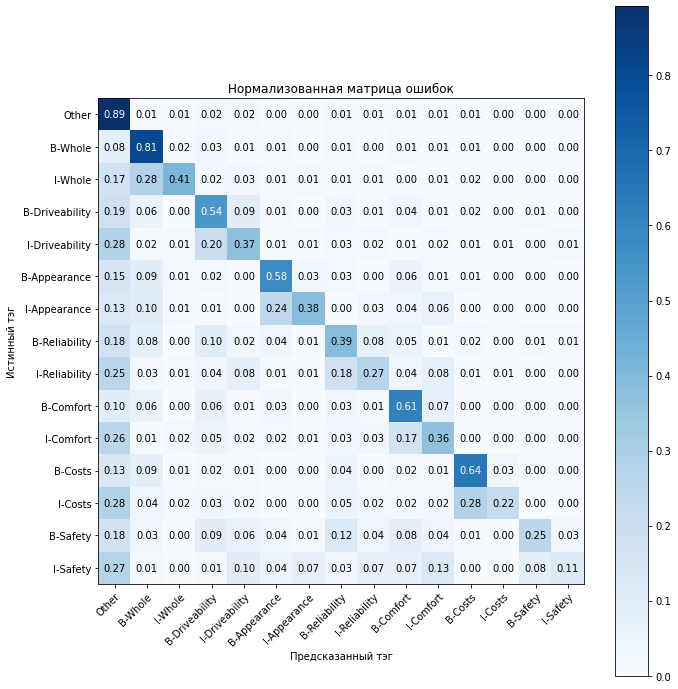

In [60]:
#hyperparameters
exp_name = 'baseline_7.1'
hyps = {
    
    #Model
    'emb_size': 300,
    'hidden_size': 32,
    'RNN_class': nn.LSTM, #nn.GRU, or nn.LSTM
    'rnn_num_layers': 1,
    'dropout_rnn': 0, #applied only if rnn_num_layer > 1
    
    #loss
    'class_weights': 'nunique_tokens', #'nunique_tokens', 'log_nunique_tokens', 'only_other_10', 
                                       #'only_other_30', 'no_weights'
    
    #optim
    'optim_class': optim.SGD, #optim.SGD, optim.Adam
    'lr': 0.1,
    'epoch_n': 5,
    'batch': None,
    
    #train_loop
    'best_loss_model': False
}

histories[exp_name] = {
    'hyps': hyps
}

TAGSET_SIZE   = len(tag_converter.tag_to_idx)

########## class_weights #############

from collections import Counter
from pprint import pprint
from math import e

if hyps['class_weights'] == 'nunique_tokens' or hyps['class_weights'] == 'log_nunique_tokens':
    tag_counter = Counter()
    for label in labels:
        tag_counter[label] = len(word_counter[label])

    #pprint(tag_counter.most_common())


    class_weights = torch.ones(15)
    class_divs    = torch.ones(15)

    for tag, inv_weight in tag_counter.most_common():
        tag_idx             = tag_converter.tags_to_index([tag])
        class_divs[tag_idx] = inv_weight

    norm       = torch.norm(class_divs, p=2, dim=0).detach()
    class_divs = class_divs.div(norm.expand_as(class_divs))

    class_weights /= class_divs
    
    if hyps['class_weights'] == 'log_nunique_tokens':
        class_weights = (class_weights * e).log()

elif hyps['class_weights'] == 'only_other_10':
    class_weights = torch.ones(15) * 10
    class_weights[-1] = 1.
    
elif hyps['class_weights'] == 'only_other_30':
    class_weights = torch.ones(15) * 30
    class_weights[-1] = 1.
    
elif hyps['class_weights'] == 'no_weights':
    class_weights = torch.ones(15)

#print(class_weights.detach())


######## Train model #########

if 'model' in locals():
    del best_model #for freeze memory
model         = LSTMTagger(hyps['emb_size'], hyps['hidden_size'], TAGSET_SIZE, word_converter,
                           num_layers = hyps['rnn_num_layers'], dropout_rnn = hyps['dropout_rnn'], RNN_class = hyps['RNN_class'])
loss_function = nn.NLLLoss(class_weights)
optimizer     = hyps['optim_class'](model.parameters(), lr=hyps['lr'])

# import psutil
# print(f"Check 01 - {psutil.virtual_memory()[2]}%")

# from livelossplot import PlotLosses

# liveplot = PlotLosses()

#statistics history
history = {'acc': {'train': [0.0],
                    'val': [0.0]},
           'acc_no_other': {'train': [0.0],
                            'val': [0.0]},
           'loss': {'train': [float('inf')],
                    'val': [float('inf')]}}
train_start_time = datetime.datetime.now()

#отбираем лучшую модель по максимальному accuracy
best_val_metric = float('-inf')   
best_epoch_i = 0
# print(f"Check 01 - {psutil.virtual_memory()[2]}%")
if 'best_model' in locals():
    del best_model #for freeze memory
best_model = copy.deepcopy(model)
# print(f"Check 02 - {psutil.virtual_memory()[2]}%")

for epoch in range(hyps['epoch_n']):
#     print(f"Check 03 - {psutil.virtual_memory()[2]}%")
    ########starting of epoch#########
    epoch_start = datetime.datetime.now()
    model.train()
    
    for i, (sentence, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
        tag_ground    = tag_converter.tags_to_index(tags) 
        
        
        loss = loss_function(tag_predicted, tag_ground)
        loss.backward()
        optimizer.step()
        
#         if i % 100 == 0:
#             liveplot.update({'negative log likelihood loss': loss.detach().numpy()})
#             liveplot.draw()
    
    ########ending of epoch#########
#     print(f"Check 04 - {psutil.virtual_memory()[2]}%")
    model.eval()
    with torch.no_grad():
        #save current epoch Train Statistics
        y_pred = []
        y_true = []
        loss_epoch = []
        for sentence, tags in training_data:
            #accuracy
            y_pred += predict_tags(model, sentence)
            y_true += tags

            #loss
            tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
            tag_ground    = tag_converter.tags_to_index(tags) 
            loss_epoch.append(loss_function(tag_predicted, tag_ground).detach().numpy())

        history['acc']['train'].append(sum(np.array(y_pred) == np.array(y_true))/len(y_pred))
        y_pred_wo_label, y_true_wo_label = get_without_label(y_pred, y_true, label='Other')
        history['acc_no_other']['train'].append(sum(np.array(y_pred_wo_label) == np.array(y_true_wo_label))/len(y_pred_wo_label))
        history['loss']['train'].append(np.array(loss_epoch).mean())
#         print(f"Check 05 - {psutil.virtual_memory()[2]}%")
        #save current epoch Val Statistics
        y_pred = []
        y_true = []
        loss_epoch = []
        for sentence, tags in test_data:
            #accuracy
            y_pred += predict_tags(model, sentence)
            y_true += tags

            #loss
            tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
            tag_ground    = tag_converter.tags_to_index(tags) 
            loss_epoch.append(loss_function(tag_predicted, tag_ground).detach().numpy())

        history['acc']['val'].append(sum(np.array(y_pred) == np.array(y_true))/len(y_pred))
        y_pred_wo_label, y_true_wo_label = get_without_label(y_pred, y_true, label='Other')
        history['acc_no_other']['val'].append(sum(np.array(y_pred_wo_label) == np.array(y_true_wo_label))/len(y_pred_wo_label))
        history['loss']['val'].append(np.array(loss_epoch).mean())
#         print(f"Check 06 - {psutil.virtual_memory()[2]}%")
    #save best model
#     print(f"Check 07 - {psutil.virtual_memory()[2]}%")
    best_model_saved = False
    if history['acc_no_other']['val'][-1] > best_val_metric:
                #отбираем модель по максимальному accuracy_no_other
                best_epoch_i = epoch
                best_val_metric = history['acc_no_other']['val'][-1]
                del best_model
#                 print(f"Check 08 - {psutil.virtual_memory()[2]}%")
                best_model = copy.deepcopy(model)
                best_model_saved = True
#     print(f"Check 09 - {psutil.virtual_memory()[2]}%")
    #output statistics
    print('Epoch={:>2}, ACC: val = {:.4f}/{:.4f}, trn = {:.4f}/{:.4f} LOSS: val = {:.4f}, trn = {:.4f}, diff = {:.4f} SAVE: {}, It: {}, T: {:0.2f}s'\
                  .format(epoch,
                          history['acc']['val'][-1], 
                          history['acc_no_other']['val'][-1],
                          history['acc']['train'][-1],
                          history['acc_no_other']['train'][-1],
                          history['loss']['val'][-1],
                          history['loss']['train'][-1],
                          history['loss']['val'][-1] - history['loss']['train'][-1],
                          best_model_saved,
                          i,
                          (datetime.datetime.now() - epoch_start).total_seconds()),
                  flush=True)

histories[exp_name] = {
    'history': history,
    'best_epoch_i': best_epoch_i,
    'full_train_time': (datetime.datetime.now() - train_start_time).total_seconds()
}

print()
print("BEST MODEL: ACC: val = {:.4f}/{:.4f}, train = {:.4f}/{:.4f}, LOSS: val = {:.4f}, train = {:.4f}, on epoch = {}, Full train time = {:0.2f}s"\
                  .format(history['acc']['val'][best_epoch_i], 
                          history['acc_no_other']['val'][best_epoch_i], 
                          history['acc']['train'][best_epoch_i],
                          history['acc_no_other']['train'][best_epoch_i],
                          history['loss']['val'][best_epoch_i],
                          history['loss']['train'][best_epoch_i],
                          best_epoch_i,
                          (datetime.datetime.now() - train_start_time).total_seconds()))

#Проверка работы на новом, не входящем в train/test комментарии (в том числе с новыми токенами)
custom_sentence = word_tokenizer.tokenize(
    'Ходовые характеристики хорошие, разгон набирает уверенно, а вот внешний вид мне не очень нравится. \
      Кондиционер охлаждает прямо очень быстро. В целом машина норм.')
try:
    tags_pred    = predict_tags(best_model, custom_sentence)

    print('предсказанные тэги:')
    text, spans = generate_markup(custom_sentence, tags_pred)

    show_markup(text, spans)
    print()
except Exception as ex:
    print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))

y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(best_model, sentence)
    y_true += tags

plot_confusion_matrix(y_true, y_pred, classes=ordered_tags, normalize=True,
                      title='Нормализованная матрица ошибок')
plt.show()

In [61]:
#mix of best experiments

Epoch= 0, ACC: val = 0.7247/0.4331, trn = 0.7340/0.4881 LOSS: val = 1.3266, trn = 1.1057, diff = 0.2209 SAVE: True, It: 2209, T: 101.71s
Epoch= 1, ACC: val = 0.7489/0.5120, trn = 0.7727/0.6359 LOSS: val = 1.2109, trn = 0.7596, diff = 0.4513 SAVE: True, It: 2209, T: 101.17s
Epoch= 2, ACC: val = 0.7629/0.5427, trn = 0.7946/0.7178 LOSS: val = 1.1949, trn = 0.5636, diff = 0.6313 SAVE: True, It: 2209, T: 100.58s
Epoch= 3, ACC: val = 0.7512/0.5613, trn = 0.7912/0.7778 LOSS: val = 1.2521, trn = 0.4472, diff = 0.8048 SAVE: True, It: 2209, T: 102.70s
Epoch= 4, ACC: val = 0.7811/0.5587, trn = 0.8348/0.8088 LOSS: val = 1.3197, trn = 0.3636, diff = 0.9561 SAVE: False, It: 2209, T: 95.28s
Epoch= 5, ACC: val = 0.7468/0.5771, trn = 0.8067/0.8486 LOSS: val = 1.2866, trn = 0.2962, diff = 0.9904 SAVE: True, It: 2209, T: 100.94s
Epoch= 6, ACC: val = 0.7740/0.5693, trn = 0.8423/0.8617 LOSS: val = 1.3924, trn = 0.2688, diff = 1.1237 SAVE: False, It: 2209, T: 96.09s
Epoch= 7, ACC: val = 0.7947/0.5741, trn =

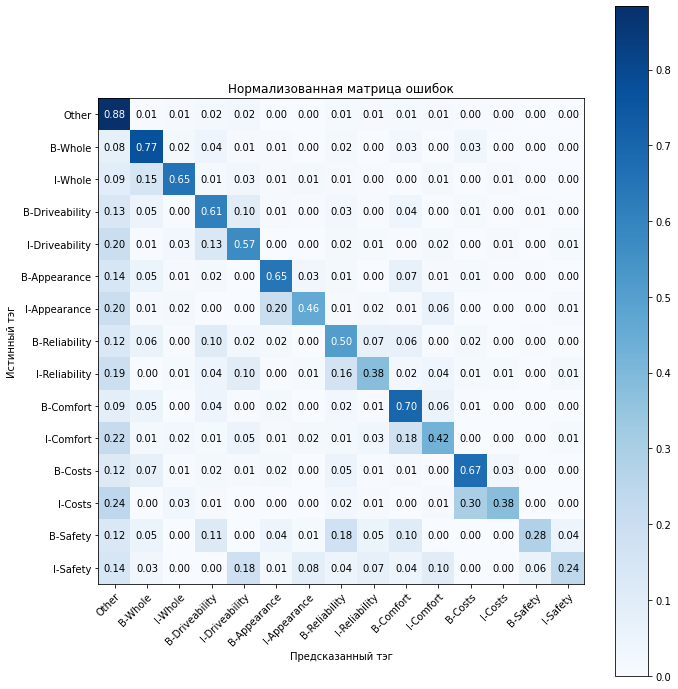

In [62]:
#hyperparameters
exp_name = 'epoch_n=30_rnn_num_layers=3_dropout_rnn=0.2_hidden_size=128_weights=only_other_30'
hyps = {
    
    #Model
    'emb_size': 300,
    'hidden_size': 120,
    'RNN_class': nn.LSTM, #nn.GRU, or nn.LSTM
    'rnn_num_layers': 3,
    'dropout_rnn': 0.2, #applied only if rnn_num_layer > 1
    
    #loss
    'class_weights': 'only_other_30', #'nunique_tokens', 'log_nunique_tokens', 'only_other_10', 
                                       #'only_other_30', 'only_other_100', 'no_weights'
    
    #optim
    'optim_class': optim.SGD, #optim.SGD, optim.Adam
    'lr': 0.1,
    'epoch_n': 30,
    'batch': None,
    
    #train_loop
    'best_loss_model': False
}

histories[exp_name] = {
    'hyps': hyps
}

TAGSET_SIZE   = len(tag_converter.tag_to_idx)

########## class_weights #############

from collections import Counter
from pprint import pprint
from math import e

if hyps['class_weights'] == 'nunique_tokens' or hyps['class_weights'] == 'log_nunique_tokens':
    tag_counter = Counter()
    for label in labels:
        tag_counter[label] = len(word_counter[label])

    #pprint(tag_counter.most_common())


    class_weights = torch.ones(15)
    class_divs    = torch.ones(15)

    for tag, inv_weight in tag_counter.most_common():
        tag_idx             = tag_converter.tags_to_index([tag])
        class_divs[tag_idx] = inv_weight

    norm       = torch.norm(class_divs, p=2, dim=0).detach()
    class_divs = class_divs.div(norm.expand_as(class_divs))

    class_weights /= class_divs
    
    if hyps['class_weights'] == 'log_nunique_tokens':
        class_weights = (class_weights * e).log()

elif hyps['class_weights'] == 'only_other_10':
    class_weights = torch.ones(15) * 10
    class_weights[-1] = 1.
    
elif hyps['class_weights'] == 'only_other_30':
    class_weights = torch.ones(15) * 30
    class_weights[-1] = 1.

elif hyps['class_weights'] == 'only_other_100':
    class_weights = torch.ones(15) * 100
    class_weights[-1] = 1.
    
elif hyps['class_weights'] == 'no_weights':
    class_weights = torch.ones(15)

#print(class_weights.detach())


######## Train model #########

if 'model' in locals():
    del best_model #for freeze memory
model         = LSTMTagger(hyps['emb_size'], hyps['hidden_size'], TAGSET_SIZE, word_converter,
                           num_layers = hyps['rnn_num_layers'], dropout_rnn = hyps['dropout_rnn'], RNN_class = hyps['RNN_class'])
loss_function = nn.NLLLoss(class_weights)
optimizer     = hyps['optim_class'](model.parameters(), lr=hyps['lr'])

# import psutil
# print(f"Check 01 - {psutil.virtual_memory()[2]}%")

# from livelossplot import PlotLosses

# liveplot = PlotLosses()

#statistics history
history = {'acc': {'train': [0.0],
                    'val': [0.0]},
           'acc_no_other': {'train': [0.0],
                            'val': [0.0]},
           'loss': {'train': [float('inf')],
                    'val': [float('inf')]}}
train_start_time = datetime.datetime.now()

#отбираем лучшую модель по максимальному accuracy
best_val_metric = float('-inf')   
best_epoch_i = 0
# print(f"Check 01 - {psutil.virtual_memory()[2]}%")
if 'best_model' in locals():
    del best_model #for freeze memory
best_model = copy.deepcopy(model)
# print(f"Check 02 - {psutil.virtual_memory()[2]}%")

for epoch in range(hyps['epoch_n']):
#     print(f"Check 03 - {psutil.virtual_memory()[2]}%")
    ########starting of epoch#########
    epoch_start = datetime.datetime.now()
    model.train()
    
    for i, (sentence, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
        tag_ground    = tag_converter.tags_to_index(tags) 
        
        
        loss = loss_function(tag_predicted, tag_ground)
        loss.backward()
        optimizer.step()
        
#         if i % 100 == 0:
#             liveplot.update({'negative log likelihood loss': loss.detach().numpy()})
#             liveplot.draw()
    
    ########ending of epoch#########
#     print(f"Check 04 - {psutil.virtual_memory()[2]}%")
    model.eval()
    with torch.no_grad():
        #save current epoch Train Statistics
        y_pred = []
        y_true = []
        loss_epoch = []
        for sentence, tags in training_data:
            #accuracy
            y_pred += predict_tags(model, sentence)
            y_true += tags

            #loss
            tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
            tag_ground    = tag_converter.tags_to_index(tags) 
            loss_epoch.append(loss_function(tag_predicted, tag_ground).detach().numpy())

        history['acc']['train'].append(sum(np.array(y_pred) == np.array(y_true))/len(y_pred))
        y_pred_wo_label, y_true_wo_label = get_without_label(y_pred, y_true, label='Other')
        history['acc_no_other']['train'].append(sum(np.array(y_pred_wo_label) == np.array(y_true_wo_label))/len(y_pred_wo_label))
        history['loss']['train'].append(np.array(loss_epoch).mean())
#         print(f"Check 05 - {psutil.virtual_memory()[2]}%")
        #save current epoch Val Statistics
        y_pred = []
        y_true = []
        loss_epoch = []
        for sentence, tags in test_data:
            #accuracy
            y_pred += predict_tags(model, sentence)
            y_true += tags

            #loss
            tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
            tag_ground    = tag_converter.tags_to_index(tags) 
            loss_epoch.append(loss_function(tag_predicted, tag_ground).detach().numpy())

        history['acc']['val'].append(sum(np.array(y_pred) == np.array(y_true))/len(y_pred))
        y_pred_wo_label, y_true_wo_label = get_without_label(y_pred, y_true, label='Other')
        history['acc_no_other']['val'].append(sum(np.array(y_pred_wo_label) == np.array(y_true_wo_label))/len(y_pred_wo_label))
        history['loss']['val'].append(np.array(loss_epoch).mean())
#         print(f"Check 06 - {psutil.virtual_memory()[2]}%")
    #save best model
#     print(f"Check 07 - {psutil.virtual_memory()[2]}%")
    best_model_saved = False
    if history['acc_no_other']['val'][-1] > best_val_metric:
                #отбираем модель по максимальному accuracy_no_other
                best_epoch_i = epoch
                best_val_metric = history['acc_no_other']['val'][-1]
                del best_model
#                 print(f"Check 08 - {psutil.virtual_memory()[2]}%")
                best_model = copy.deepcopy(model)
                best_model_saved = True
#     print(f"Check 09 - {psutil.virtual_memory()[2]}%")
    #output statistics
    print('Epoch={:>2}, ACC: val = {:.4f}/{:.4f}, trn = {:.4f}/{:.4f} LOSS: val = {:.4f}, trn = {:.4f}, diff = {:.4f} SAVE: {}, It: {}, T: {:0.2f}s'\
                  .format(epoch,
                          history['acc']['val'][-1], 
                          history['acc_no_other']['val'][-1],
                          history['acc']['train'][-1],
                          history['acc_no_other']['train'][-1],
                          history['loss']['val'][-1],
                          history['loss']['train'][-1],
                          history['loss']['val'][-1] - history['loss']['train'][-1],
                          best_model_saved,
                          i,
                          (datetime.datetime.now() - epoch_start).total_seconds()),
                  flush=True)

histories[exp_name] = {
    'history': history,
    'best_epoch_i': best_epoch_i,
    'full_train_time': (datetime.datetime.now() - train_start_time).total_seconds()
}

print()
print("BEST MODEL: ACC: val = {:.4f}/{:.4f}, train = {:.4f}/{:.4f}, LOSS: val = {:.4f}, train = {:.4f}, on epoch = {}, Full train time = {:0.2f}s"\
                  .format(history['acc']['val'][best_epoch_i], 
                          history['acc_no_other']['val'][best_epoch_i], 
                          history['acc']['train'][best_epoch_i],
                          history['acc_no_other']['train'][best_epoch_i],
                          history['loss']['val'][best_epoch_i],
                          history['loss']['train'][best_epoch_i],
                          best_epoch_i,
                          (datetime.datetime.now() - train_start_time).total_seconds()))

#Проверка работы на новом, не входящем в train/test комментарии (в том числе с новыми токенами)
custom_sentence = word_tokenizer.tokenize(
    'Ходовые характеристики хорошие, разгон набирает уверенно, а вот внешний вид мне не очень нравится. \
      Кондиционер охлаждает прямо очень быстро. В целом машина норм.')
try:
    tags_pred    = predict_tags(best_model, custom_sentence)

    print('предсказанные тэги:')
    text, spans = generate_markup(custom_sentence, tags_pred)

    show_markup(text, spans)
    print()
except Exception as ex:
    print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))

y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(best_model, sentence)
    y_true += tags

plot_confusion_matrix(y_true, y_pred, classes=ordered_tags, normalize=True,
                      title='Нормализованная матрица ошибок')
plt.show()

Epoch= 0, ACC: val = 0.6797/0.4276, trn = 0.6852/0.4780 LOSS: val = 1.3927, trn = 1.1518, diff = 0.2409 SAVE: True, It: 2209, T: 101.92s
Epoch= 1, ACC: val = 0.6753/0.5377, trn = 0.6854/0.6512 LOSS: val = 1.1856, trn = 0.7373, diff = 0.4483 SAVE: True, It: 2209, T: 101.62s
Epoch= 2, ACC: val = 0.6768/0.5763, trn = 0.6931/0.7303 LOSS: val = 1.1749, trn = 0.5513, diff = 0.6236 SAVE: True, It: 2209, T: 101.44s
Epoch= 3, ACC: val = 0.7131/0.5722, trn = 0.7368/0.7691 LOSS: val = 1.2625, trn = 0.4370, diff = 0.8255 SAVE: False, It: 2209, T: 96.12s
Epoch= 4, ACC: val = 0.6783/0.5974, trn = 0.7073/0.8129 LOSS: val = 1.2083, trn = 0.3488, diff = 0.8595 SAVE: True, It: 2209, T: 103.18s
Epoch= 5, ACC: val = 0.6006/0.6068, trn = 0.6318/0.8512 LOSS: val = 1.2793, trn = 0.3289, diff = 0.9504 SAVE: True, It: 2209, T: 102.78s
Epoch= 6, ACC: val = 0.7284/0.5907, trn = 0.7755/0.8841 LOSS: val = 1.3502, trn = 0.2060, diff = 1.1442 SAVE: False, It: 2209, T: 95.49s
Epoch= 7, ACC: val = 0.7100/0.6024, trn =

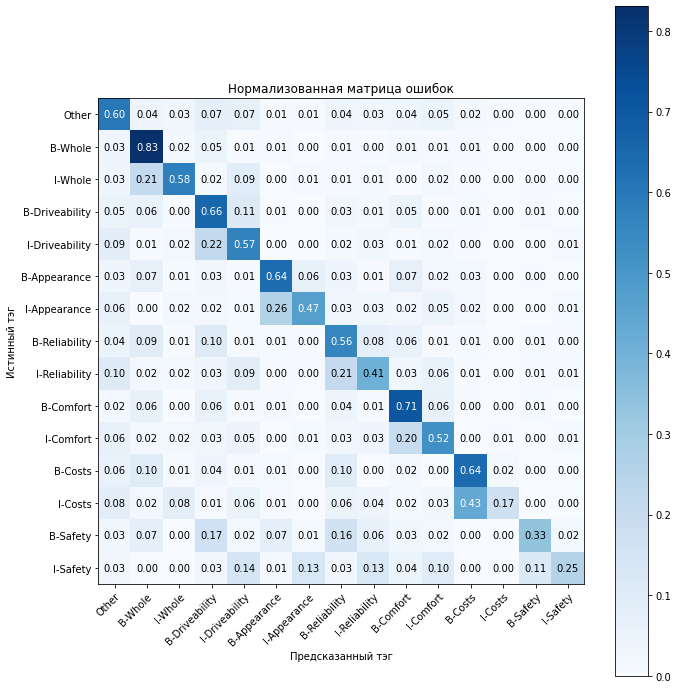

In [63]:
#hyperparameters
exp_name = 'epoch_n=30_rnn_num_layers=3_dropout_rnn=0.2_hidden_size=128_weights=only_other_100'
hyps = {
    
    #Model
    'emb_size': 300,
    'hidden_size': 120,
    'RNN_class': nn.LSTM, #nn.GRU, or nn.LSTM
    'rnn_num_layers': 3,
    'dropout_rnn': 0.2, #applied only if rnn_num_layer > 1
    
    #loss
    'class_weights': 'only_other_100', #'nunique_tokens', 'log_nunique_tokens', 'only_other_10', 
                                       #'only_other_30', 'only_other_100', 'no_weights'
    
    #optim
    'optim_class': optim.SGD, #optim.SGD, optim.Adam
    'lr': 0.1,
    'epoch_n': 30,
    'batch': None,
    
    #train_loop
    'best_loss_model': False
}

histories[exp_name] = {
    'hyps': hyps
}

TAGSET_SIZE   = len(tag_converter.tag_to_idx)

########## class_weights #############

from collections import Counter
from pprint import pprint
from math import e

if hyps['class_weights'] == 'nunique_tokens' or hyps['class_weights'] == 'log_nunique_tokens':
    tag_counter = Counter()
    for label in labels:
        tag_counter[label] = len(word_counter[label])

    #pprint(tag_counter.most_common())


    class_weights = torch.ones(15)
    class_divs    = torch.ones(15)

    for tag, inv_weight in tag_counter.most_common():
        tag_idx             = tag_converter.tags_to_index([tag])
        class_divs[tag_idx] = inv_weight

    norm       = torch.norm(class_divs, p=2, dim=0).detach()
    class_divs = class_divs.div(norm.expand_as(class_divs))

    class_weights /= class_divs
    
    if hyps['class_weights'] == 'log_nunique_tokens':
        class_weights = (class_weights * e).log()

elif hyps['class_weights'] == 'only_other_10':
    class_weights = torch.ones(15) * 10
    class_weights[-1] = 1.
    
elif hyps['class_weights'] == 'only_other_30':
    class_weights = torch.ones(15) * 30
    class_weights[-1] = 1.

elif hyps['class_weights'] == 'only_other_100':
    class_weights = torch.ones(15) * 100
    class_weights[-1] = 1.
    
elif hyps['class_weights'] == 'no_weights':
    class_weights = torch.ones(15)

#print(class_weights.detach())


######## Train model #########

if 'model' in locals():
    del best_model #for freeze memory
model         = LSTMTagger(hyps['emb_size'], hyps['hidden_size'], TAGSET_SIZE, word_converter,
                           num_layers = hyps['rnn_num_layers'], dropout_rnn = hyps['dropout_rnn'], RNN_class = hyps['RNN_class'])
loss_function = nn.NLLLoss(class_weights)
optimizer     = hyps['optim_class'](model.parameters(), lr=hyps['lr'])

# import psutil
# print(f"Check 01 - {psutil.virtual_memory()[2]}%")

# from livelossplot import PlotLosses

# liveplot = PlotLosses()

#statistics history
history = {'acc': {'train': [0.0],
                    'val': [0.0]},
           'acc_no_other': {'train': [0.0],
                            'val': [0.0]},
           'loss': {'train': [float('inf')],
                    'val': [float('inf')]}}
train_start_time = datetime.datetime.now()

#отбираем лучшую модель по максимальному accuracy
best_val_metric = float('-inf')   
best_epoch_i = 0
# print(f"Check 01 - {psutil.virtual_memory()[2]}%")
if 'best_model' in locals():
    del best_model #for freeze memory
best_model = copy.deepcopy(model)
# print(f"Check 02 - {psutil.virtual_memory()[2]}%")

for epoch in range(hyps['epoch_n']):
#     print(f"Check 03 - {psutil.virtual_memory()[2]}%")
    ########starting of epoch#########
    epoch_start = datetime.datetime.now()
    model.train()
    
    for i, (sentence, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
        tag_ground    = tag_converter.tags_to_index(tags) 
        
        
        loss = loss_function(tag_predicted, tag_ground)
        loss.backward()
        optimizer.step()
        
#         if i % 100 == 0:
#             liveplot.update({'negative log likelihood loss': loss.detach().numpy()})
#             liveplot.draw()
    
    ########ending of epoch#########
#     print(f"Check 04 - {psutil.virtual_memory()[2]}%")
    model.eval()
    with torch.no_grad():
        #save current epoch Train Statistics
        y_pred = []
        y_true = []
        loss_epoch = []
        for sentence, tags in training_data:
            #accuracy
            y_pred += predict_tags(model, sentence)
            y_true += tags

            #loss
            tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
            tag_ground    = tag_converter.tags_to_index(tags) 
            loss_epoch.append(loss_function(tag_predicted, tag_ground).detach().numpy())

        history['acc']['train'].append(sum(np.array(y_pred) == np.array(y_true))/len(y_pred))
        y_pred_wo_label, y_true_wo_label = get_without_label(y_pred, y_true, label='Other')
        history['acc_no_other']['train'].append(sum(np.array(y_pred_wo_label) == np.array(y_true_wo_label))/len(y_pred_wo_label))
        history['loss']['train'].append(np.array(loss_epoch).mean())
#         print(f"Check 05 - {psutil.virtual_memory()[2]}%")
        #save current epoch Val Statistics
        y_pred = []
        y_true = []
        loss_epoch = []
        for sentence, tags in test_data:
            #accuracy
            y_pred += predict_tags(model, sentence)
            y_true += tags

            #loss
            tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
            tag_ground    = tag_converter.tags_to_index(tags) 
            loss_epoch.append(loss_function(tag_predicted, tag_ground).detach().numpy())

        history['acc']['val'].append(sum(np.array(y_pred) == np.array(y_true))/len(y_pred))
        y_pred_wo_label, y_true_wo_label = get_without_label(y_pred, y_true, label='Other')
        history['acc_no_other']['val'].append(sum(np.array(y_pred_wo_label) == np.array(y_true_wo_label))/len(y_pred_wo_label))
        history['loss']['val'].append(np.array(loss_epoch).mean())
#         print(f"Check 06 - {psutil.virtual_memory()[2]}%")
    #save best model
#     print(f"Check 07 - {psutil.virtual_memory()[2]}%")
    best_model_saved = False
    if history['acc_no_other']['val'][-1] > best_val_metric:
                #отбираем модель по максимальному accuracy_no_other
                best_epoch_i = epoch
                best_val_metric = history['acc_no_other']['val'][-1]
                del best_model
#                 print(f"Check 08 - {psutil.virtual_memory()[2]}%")
                best_model = copy.deepcopy(model)
                best_model_saved = True
#     print(f"Check 09 - {psutil.virtual_memory()[2]}%")
    #output statistics
    print('Epoch={:>2}, ACC: val = {:.4f}/{:.4f}, trn = {:.4f}/{:.4f} LOSS: val = {:.4f}, trn = {:.4f}, diff = {:.4f} SAVE: {}, It: {}, T: {:0.2f}s'\
                  .format(epoch,
                          history['acc']['val'][-1], 
                          history['acc_no_other']['val'][-1],
                          history['acc']['train'][-1],
                          history['acc_no_other']['train'][-1],
                          history['loss']['val'][-1],
                          history['loss']['train'][-1],
                          history['loss']['val'][-1] - history['loss']['train'][-1],
                          best_model_saved,
                          i,
                          (datetime.datetime.now() - epoch_start).total_seconds()),
                  flush=True)

histories[exp_name] = {
    'history': history,
    'best_epoch_i': best_epoch_i,
    'full_train_time': (datetime.datetime.now() - train_start_time).total_seconds()
}

print()
print("BEST MODEL: ACC: val = {:.4f}/{:.4f}, train = {:.4f}/{:.4f}, LOSS: val = {:.4f}, train = {:.4f}, on epoch = {}, Full train time = {:0.2f}s"\
                  .format(history['acc']['val'][best_epoch_i], 
                          history['acc_no_other']['val'][best_epoch_i], 
                          history['acc']['train'][best_epoch_i],
                          history['acc_no_other']['train'][best_epoch_i],
                          history['loss']['val'][best_epoch_i],
                          history['loss']['train'][best_epoch_i],
                          best_epoch_i,
                          (datetime.datetime.now() - train_start_time).total_seconds()))

#Проверка работы на новом, не входящем в train/test комментарии (в том числе с новыми токенами)
custom_sentence = word_tokenizer.tokenize(
    'Ходовые характеристики хорошие, разгон набирает уверенно, а вот внешний вид мне не очень нравится. \
      Кондиционер охлаждает прямо очень быстро. В целом машина норм.')
try:
    tags_pred    = predict_tags(best_model, custom_sentence)

    print('предсказанные тэги:')
    text, spans = generate_markup(custom_sentence, tags_pred)

    show_markup(text, spans)
    print()
except Exception as ex:
    print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))

y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(best_model, sentence)
    y_true += tags

plot_confusion_matrix(y_true, y_pred, classes=ordered_tags, normalize=True,
                      title='Нормализованная матрица ошибок')
plt.show()

Epoch= 0, ACC: val = 0.7520/0.0000, trn = 0.7693/0.0000 LOSS: val = 2.3723, trn = 2.3496, diff = 0.0227 SAVE: True, It: 2209, T: 184.40s
Epoch= 1, ACC: val = 0.5766/0.1289, trn = 0.5794/0.1249 LOSS: val = 2.1606, trn = 2.0708, diff = 0.0898 SAVE: True, It: 2209, T: 186.21s
Epoch= 2, ACC: val = 0.6105/0.2381, trn = 0.6170/0.2493 LOSS: val = 1.8059, trn = 1.6317, diff = 0.1742 SAVE: True, It: 2209, T: 182.96s
Epoch= 3, ACC: val = 0.6481/0.3390, trn = 0.6580/0.3913 LOSS: val = 1.6364, trn = 1.2858, diff = 0.3506 SAVE: True, It: 2209, T: 183.24s
Epoch= 4, ACC: val = 0.7059/0.4188, trn = 0.7226/0.5021 LOSS: val = 1.4972, trn = 1.0173, diff = 0.4798 SAVE: True, It: 2209, T: 184.92s
Epoch= 5, ACC: val = 0.6800/0.3990, trn = 0.7068/0.5180 LOSS: val = 1.5859, trn = 1.0161, diff = 0.5698 SAVE: False, It: 2209, T: 180.66s
Epoch= 6, ACC: val = 0.7059/0.4629, trn = 0.7404/0.6185 LOSS: val = 1.4874, trn = 0.7451, diff = 0.7423 SAVE: True, It: 2209, T: 185.95s
Epoch= 7, ACC: val = 0.7329/0.4750, trn 

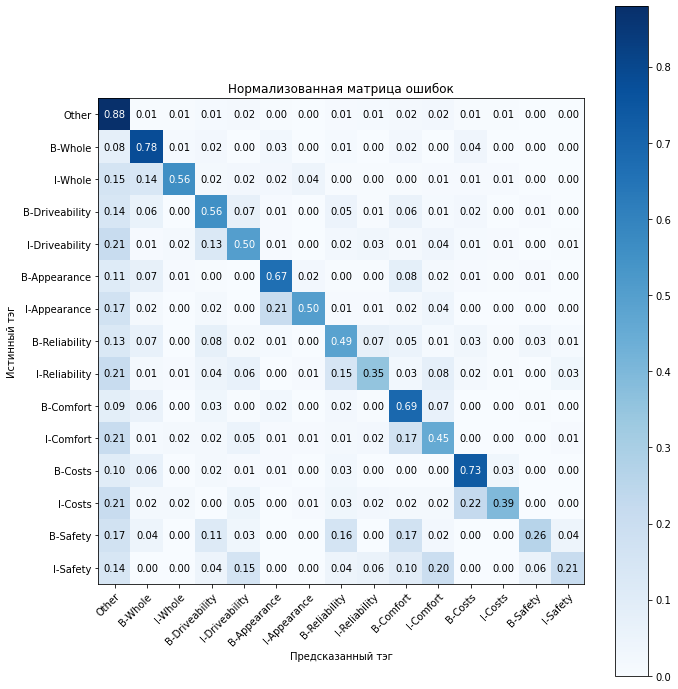

In [64]:
#hyperparameters
exp_name = 'epoch_n=30_rnn_num_layers=6_dropout_rnn=0.2_hidden_size=128_weights=only_other_30'
hyps = {
    
    #Model
    'emb_size': 300,
    'hidden_size': 120,
    'RNN_class': nn.LSTM, #nn.GRU, or nn.LSTM
    'rnn_num_layers': 6,
    'dropout_rnn': 0.2, #applied only if rnn_num_layer > 1
    
    #loss
    'class_weights': 'only_other_30', #'nunique_tokens', 'log_nunique_tokens', 'only_other_10', 
                                       #'only_other_30', 'only_other_100', 'no_weights'
    
    #optim
    'optim_class': optim.SGD, #optim.SGD, optim.Adam
    'lr': 0.1,
    'epoch_n': 30,
    'batch': None,
    
    #train_loop
    'best_loss_model': False
}

histories[exp_name] = {
    'hyps': hyps
}

TAGSET_SIZE   = len(tag_converter.tag_to_idx)

########## class_weights #############

from collections import Counter
from pprint import pprint
from math import e

if hyps['class_weights'] == 'nunique_tokens' or hyps['class_weights'] == 'log_nunique_tokens':
    tag_counter = Counter()
    for label in labels:
        tag_counter[label] = len(word_counter[label])

    #pprint(tag_counter.most_common())


    class_weights = torch.ones(15)
    class_divs    = torch.ones(15)

    for tag, inv_weight in tag_counter.most_common():
        tag_idx             = tag_converter.tags_to_index([tag])
        class_divs[tag_idx] = inv_weight

    norm       = torch.norm(class_divs, p=2, dim=0).detach()
    class_divs = class_divs.div(norm.expand_as(class_divs))

    class_weights /= class_divs
    
    if hyps['class_weights'] == 'log_nunique_tokens':
        class_weights = (class_weights * e).log()

elif hyps['class_weights'] == 'only_other_10':
    class_weights = torch.ones(15) * 10
    class_weights[-1] = 1.
    
elif hyps['class_weights'] == 'only_other_30':
    class_weights = torch.ones(15) * 30
    class_weights[-1] = 1.

elif hyps['class_weights'] == 'only_other_100':
    class_weights = torch.ones(15) * 100
    class_weights[-1] = 1.
    
elif hyps['class_weights'] == 'no_weights':
    class_weights = torch.ones(15)

#print(class_weights.detach())


######## Train model #########

if 'model' in locals():
    del best_model #for freeze memory
model         = LSTMTagger(hyps['emb_size'], hyps['hidden_size'], TAGSET_SIZE, word_converter,
                           num_layers = hyps['rnn_num_layers'], dropout_rnn = hyps['dropout_rnn'], RNN_class = hyps['RNN_class'])
loss_function = nn.NLLLoss(class_weights)
optimizer     = hyps['optim_class'](model.parameters(), lr=hyps['lr'])

# import psutil
# print(f"Check 01 - {psutil.virtual_memory()[2]}%")

# from livelossplot import PlotLosses

# liveplot = PlotLosses()

#statistics history
history = {'acc': {'train': [0.0],
                    'val': [0.0]},
           'acc_no_other': {'train': [0.0],
                            'val': [0.0]},
           'loss': {'train': [float('inf')],
                    'val': [float('inf')]}}
train_start_time = datetime.datetime.now()

#отбираем лучшую модель по максимальному accuracy
best_val_metric = float('-inf')   
best_epoch_i = 0
# print(f"Check 01 - {psutil.virtual_memory()[2]}%")
if 'best_model' in locals():
    del best_model #for freeze memory
best_model = copy.deepcopy(model)
# print(f"Check 02 - {psutil.virtual_memory()[2]}%")

for epoch in range(hyps['epoch_n']):
#     print(f"Check 03 - {psutil.virtual_memory()[2]}%")
    ########starting of epoch#########
    epoch_start = datetime.datetime.now()
    model.train()
    
    for i, (sentence, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
        tag_ground    = tag_converter.tags_to_index(tags) 
        
        
        loss = loss_function(tag_predicted, tag_ground)
        loss.backward()
        optimizer.step()
        
#         if i % 100 == 0:
#             liveplot.update({'negative log likelihood loss': loss.detach().numpy()})
#             liveplot.draw()
    
    ########ending of epoch#########
#     print(f"Check 04 - {psutil.virtual_memory()[2]}%")
    model.eval()
    with torch.no_grad():
        #save current epoch Train Statistics
        y_pred = []
        y_true = []
        loss_epoch = []
        for sentence, tags in training_data:
            #accuracy
            y_pred += predict_tags(model, sentence)
            y_true += tags

            #loss
            tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
            tag_ground    = tag_converter.tags_to_index(tags) 
            loss_epoch.append(loss_function(tag_predicted, tag_ground).detach().numpy())

        history['acc']['train'].append(sum(np.array(y_pred) == np.array(y_true))/len(y_pred))
        y_pred_wo_label, y_true_wo_label = get_without_label(y_pred, y_true, label='Other')
        history['acc_no_other']['train'].append(sum(np.array(y_pred_wo_label) == np.array(y_true_wo_label))/len(y_pred_wo_label))
        history['loss']['train'].append(np.array(loss_epoch).mean())
#         print(f"Check 05 - {psutil.virtual_memory()[2]}%")
        #save current epoch Val Statistics
        y_pred = []
        y_true = []
        loss_epoch = []
        for sentence, tags in test_data:
            #accuracy
            y_pred += predict_tags(model, sentence)
            y_true += tags

            #loss
            tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
            tag_ground    = tag_converter.tags_to_index(tags) 
            loss_epoch.append(loss_function(tag_predicted, tag_ground).detach().numpy())

        history['acc']['val'].append(sum(np.array(y_pred) == np.array(y_true))/len(y_pred))
        y_pred_wo_label, y_true_wo_label = get_without_label(y_pred, y_true, label='Other')
        history['acc_no_other']['val'].append(sum(np.array(y_pred_wo_label) == np.array(y_true_wo_label))/len(y_pred_wo_label))
        history['loss']['val'].append(np.array(loss_epoch).mean())
#         print(f"Check 06 - {psutil.virtual_memory()[2]}%")
    #save best model
#     print(f"Check 07 - {psutil.virtual_memory()[2]}%")
    best_model_saved = False
    if history['acc_no_other']['val'][-1] > best_val_metric:
                #отбираем модель по максимальному accuracy_no_other
                best_epoch_i = epoch
                best_val_metric = history['acc_no_other']['val'][-1]
                del best_model
#                 print(f"Check 08 - {psutil.virtual_memory()[2]}%")
                best_model = copy.deepcopy(model)
                best_model_saved = True
#     print(f"Check 09 - {psutil.virtual_memory()[2]}%")
    #output statistics
    print('Epoch={:>2}, ACC: val = {:.4f}/{:.4f}, trn = {:.4f}/{:.4f} LOSS: val = {:.4f}, trn = {:.4f}, diff = {:.4f} SAVE: {}, It: {}, T: {:0.2f}s'\
                  .format(epoch,
                          history['acc']['val'][-1], 
                          history['acc_no_other']['val'][-1],
                          history['acc']['train'][-1],
                          history['acc_no_other']['train'][-1],
                          history['loss']['val'][-1],
                          history['loss']['train'][-1],
                          history['loss']['val'][-1] - history['loss']['train'][-1],
                          best_model_saved,
                          i,
                          (datetime.datetime.now() - epoch_start).total_seconds()),
                  flush=True)

histories[exp_name] = {
    'history': history,
    'best_epoch_i': best_epoch_i,
    'full_train_time': (datetime.datetime.now() - train_start_time).total_seconds()
}

print()
print("BEST MODEL: ACC: val = {:.4f}/{:.4f}, train = {:.4f}/{:.4f}, LOSS: val = {:.4f}, train = {:.4f}, on epoch = {}, Full train time = {:0.2f}s"\
                  .format(history['acc']['val'][best_epoch_i], 
                          history['acc_no_other']['val'][best_epoch_i], 
                          history['acc']['train'][best_epoch_i],
                          history['acc_no_other']['train'][best_epoch_i],
                          history['loss']['val'][best_epoch_i],
                          history['loss']['train'][best_epoch_i],
                          best_epoch_i,
                          (datetime.datetime.now() - train_start_time).total_seconds()))

#Проверка работы на новом, не входящем в train/test комментарии (в том числе с новыми токенами)
custom_sentence = word_tokenizer.tokenize(
    'Ходовые характеристики хорошие, разгон набирает уверенно, а вот внешний вид мне не очень нравится. \
      Кондиционер охлаждает прямо очень быстро. В целом машина норм.')
try:
    tags_pred    = predict_tags(best_model, custom_sentence)

    print('предсказанные тэги:')
    text, spans = generate_markup(custom_sentence, tags_pred)

    show_markup(text, spans)
    print()
except Exception as ex:
    print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))

y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(best_model, sentence)
    y_true += tags

plot_confusion_matrix(y_true, y_pred, classes=ordered_tags, normalize=True,
                      title='Нормализованная матрица ошибок')
plt.show()

Epoch= 0, ACC: val = 0.7293/0.4450, trn = 0.7420/0.5082 LOSS: val = 1.2786, trn = 1.0505, diff = 0.2281 SAVE: True, It: 2209, T: 156.49s
Epoch= 1, ACC: val = 0.7465/0.5284, trn = 0.7705/0.6563 LOSS: val = 1.1536, trn = 0.7148, diff = 0.4388 SAVE: True, It: 2209, T: 158.71s
Epoch= 2, ACC: val = 0.7612/0.5451, trn = 0.7970/0.7303 LOSS: val = 1.2161, trn = 0.5275, diff = 0.6886 SAVE: True, It: 2209, T: 158.02s
Epoch= 3, ACC: val = 0.7807/0.5482, trn = 0.8276/0.7740 LOSS: val = 1.3830, trn = 0.4377, diff = 0.9453 SAVE: True, It: 2209, T: 159.08s
Epoch= 4, ACC: val = 0.7894/0.5692, trn = 0.8502/0.8472 LOSS: val = 1.3463, trn = 0.2846, diff = 1.0616 SAVE: True, It: 2209, T: 155.94s
Epoch= 5, ACC: val = 0.7856/0.5561, trn = 0.8568/0.8631 LOSS: val = 1.4339, trn = 0.2616, diff = 1.1723 SAVE: False, It: 2209, T: 151.38s
Epoch= 6, ACC: val = 0.8056/0.5805, trn = 0.8859/0.8940 LOSS: val = 1.4743, trn = 0.1814, diff = 1.2929 SAVE: True, It: 2209, T: 157.76s
Epoch= 7, ACC: val = 0.7869/0.5837, trn 

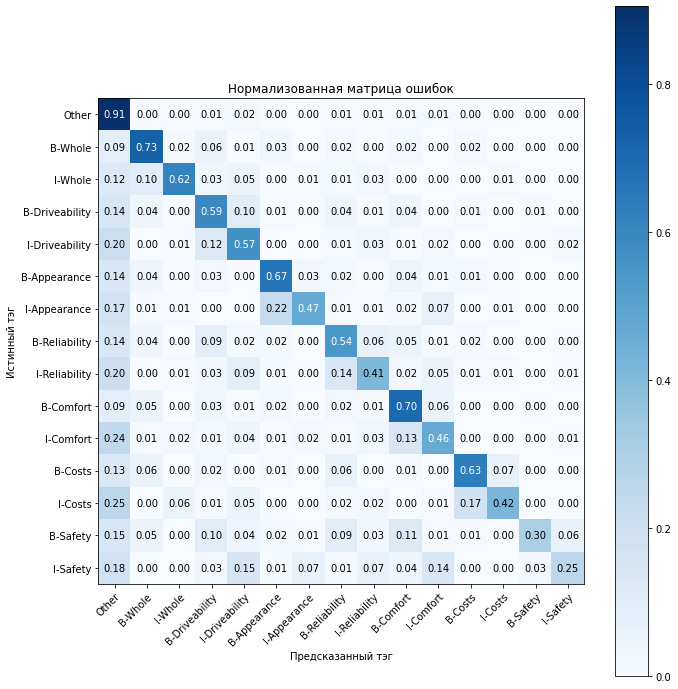

In [65]:
#hyperparameters
exp_name = 'epoch_n=30_rnn_num_layers=3_dropout_rnn=0.2_hidden_size=240_weights=only_other_30'
hyps = {
    
    #Model
    'emb_size': 300,
    'hidden_size': 240,
    'RNN_class': nn.LSTM, #nn.GRU, or nn.LSTM
    'rnn_num_layers': 3,
    'dropout_rnn': 0.2, #applied only if rnn_num_layer > 1
    
    #loss
    'class_weights': 'only_other_30', #'nunique_tokens', 'log_nunique_tokens', 'only_other_10', 
                                       #'only_other_30', 'only_other_100', 'no_weights'
    
    #optim
    'optim_class': optim.SGD, #optim.SGD, optim.Adam
    'lr': 0.1,
    'epoch_n': 30,
    'batch': None,
    
    #train_loop
    'best_loss_model': False
}

histories[exp_name] = {
    'hyps': hyps
}

TAGSET_SIZE   = len(tag_converter.tag_to_idx)

########## class_weights #############

from collections import Counter
from pprint import pprint
from math import e

if hyps['class_weights'] == 'nunique_tokens' or hyps['class_weights'] == 'log_nunique_tokens':
    tag_counter = Counter()
    for label in labels:
        tag_counter[label] = len(word_counter[label])

    #pprint(tag_counter.most_common())


    class_weights = torch.ones(15)
    class_divs    = torch.ones(15)

    for tag, inv_weight in tag_counter.most_common():
        tag_idx             = tag_converter.tags_to_index([tag])
        class_divs[tag_idx] = inv_weight

    norm       = torch.norm(class_divs, p=2, dim=0).detach()
    class_divs = class_divs.div(norm.expand_as(class_divs))

    class_weights /= class_divs
    
    if hyps['class_weights'] == 'log_nunique_tokens':
        class_weights = (class_weights * e).log()

elif hyps['class_weights'] == 'only_other_10':
    class_weights = torch.ones(15) * 10
    class_weights[-1] = 1.
    
elif hyps['class_weights'] == 'only_other_30':
    class_weights = torch.ones(15) * 30
    class_weights[-1] = 1.

elif hyps['class_weights'] == 'only_other_100':
    class_weights = torch.ones(15) * 100
    class_weights[-1] = 1.
    
elif hyps['class_weights'] == 'no_weights':
    class_weights = torch.ones(15)

#print(class_weights.detach())


######## Train model #########

if 'model' in locals():
    del best_model #for freeze memory
model         = LSTMTagger(hyps['emb_size'], hyps['hidden_size'], TAGSET_SIZE, word_converter,
                           num_layers = hyps['rnn_num_layers'], dropout_rnn = hyps['dropout_rnn'], RNN_class = hyps['RNN_class'])
loss_function = nn.NLLLoss(class_weights)
optimizer     = hyps['optim_class'](model.parameters(), lr=hyps['lr'])

# import psutil
# print(f"Check 01 - {psutil.virtual_memory()[2]}%")

# from livelossplot import PlotLosses

# liveplot = PlotLosses()

#statistics history
history = {'acc': {'train': [0.0],
                    'val': [0.0]},
           'acc_no_other': {'train': [0.0],
                            'val': [0.0]},
           'loss': {'train': [float('inf')],
                    'val': [float('inf')]}}
train_start_time = datetime.datetime.now()

#отбираем лучшую модель по максимальному accuracy
best_val_metric = float('-inf')   
best_epoch_i = 0
# print(f"Check 01 - {psutil.virtual_memory()[2]}%")
if 'best_model' in locals():
    del best_model #for freeze memory
best_model = copy.deepcopy(model)
# print(f"Check 02 - {psutil.virtual_memory()[2]}%")

for epoch in range(hyps['epoch_n']):
#     print(f"Check 03 - {psutil.virtual_memory()[2]}%")
    ########starting of epoch#########
    epoch_start = datetime.datetime.now()
    model.train()
    
    for i, (sentence, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
        tag_ground    = tag_converter.tags_to_index(tags) 
        
        
        loss = loss_function(tag_predicted, tag_ground)
        loss.backward()
        optimizer.step()
        
#         if i % 100 == 0:
#             liveplot.update({'negative log likelihood loss': loss.detach().numpy()})
#             liveplot.draw()
    
    ########ending of epoch#########
#     print(f"Check 04 - {psutil.virtual_memory()[2]}%")
    model.eval()
    with torch.no_grad():
        #save current epoch Train Statistics
        y_pred = []
        y_true = []
        loss_epoch = []
        for sentence, tags in training_data:
            #accuracy
            y_pred += predict_tags(model, sentence)
            y_true += tags

            #loss
            tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
            tag_ground    = tag_converter.tags_to_index(tags) 
            loss_epoch.append(loss_function(tag_predicted, tag_ground).detach().numpy())

        history['acc']['train'].append(sum(np.array(y_pred) == np.array(y_true))/len(y_pred))
        y_pred_wo_label, y_true_wo_label = get_without_label(y_pred, y_true, label='Other')
        history['acc_no_other']['train'].append(sum(np.array(y_pred_wo_label) == np.array(y_true_wo_label))/len(y_pred_wo_label))
        history['loss']['train'].append(np.array(loss_epoch).mean())
#         print(f"Check 05 - {psutil.virtual_memory()[2]}%")
        #save current epoch Val Statistics
        y_pred = []
        y_true = []
        loss_epoch = []
        for sentence, tags in test_data:
            #accuracy
            y_pred += predict_tags(model, sentence)
            y_true += tags

            #loss
            tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
            tag_ground    = tag_converter.tags_to_index(tags) 
            loss_epoch.append(loss_function(tag_predicted, tag_ground).detach().numpy())

        history['acc']['val'].append(sum(np.array(y_pred) == np.array(y_true))/len(y_pred))
        y_pred_wo_label, y_true_wo_label = get_without_label(y_pred, y_true, label='Other')
        history['acc_no_other']['val'].append(sum(np.array(y_pred_wo_label) == np.array(y_true_wo_label))/len(y_pred_wo_label))
        history['loss']['val'].append(np.array(loss_epoch).mean())
#         print(f"Check 06 - {psutil.virtual_memory()[2]}%")
    #save best model
#     print(f"Check 07 - {psutil.virtual_memory()[2]}%")
    best_model_saved = False
    if history['acc_no_other']['val'][-1] > best_val_metric:
                #отбираем модель по максимальному accuracy_no_other
                best_epoch_i = epoch
                best_val_metric = history['acc_no_other']['val'][-1]
                del best_model
#                 print(f"Check 08 - {psutil.virtual_memory()[2]}%")
                best_model = copy.deepcopy(model)
                best_model_saved = True
#     print(f"Check 09 - {psutil.virtual_memory()[2]}%")
    #output statistics
    print('Epoch={:>2}, ACC: val = {:.4f}/{:.4f}, trn = {:.4f}/{:.4f} LOSS: val = {:.4f}, trn = {:.4f}, diff = {:.4f} SAVE: {}, It: {}, T: {:0.2f}s'\
                  .format(epoch,
                          history['acc']['val'][-1], 
                          history['acc_no_other']['val'][-1],
                          history['acc']['train'][-1],
                          history['acc_no_other']['train'][-1],
                          history['loss']['val'][-1],
                          history['loss']['train'][-1],
                          history['loss']['val'][-1] - history['loss']['train'][-1],
                          best_model_saved,
                          i,
                          (datetime.datetime.now() - epoch_start).total_seconds()),
                  flush=True)

histories[exp_name] = {
    'history': history,
    'best_epoch_i': best_epoch_i,
    'full_train_time': (datetime.datetime.now() - train_start_time).total_seconds()
}

print()
print("BEST MODEL: ACC: val = {:.4f}/{:.4f}, train = {:.4f}/{:.4f}, LOSS: val = {:.4f}, train = {:.4f}, on epoch = {}, Full train time = {:0.2f}s"\
                  .format(history['acc']['val'][best_epoch_i], 
                          history['acc_no_other']['val'][best_epoch_i], 
                          history['acc']['train'][best_epoch_i],
                          history['acc_no_other']['train'][best_epoch_i],
                          history['loss']['val'][best_epoch_i],
                          history['loss']['train'][best_epoch_i],
                          best_epoch_i,
                          (datetime.datetime.now() - train_start_time).total_seconds()))

#Проверка работы на новом, не входящем в train/test комментарии (в том числе с новыми токенами)
custom_sentence = word_tokenizer.tokenize(
    'Ходовые характеристики хорошие, разгон набирает уверенно, а вот внешний вид мне не очень нравится. \
      Кондиционер охлаждает прямо очень быстро. В целом машина норм.')
try:
    tags_pred    = predict_tags(best_model, custom_sentence)

    print('предсказанные тэги:')
    text, spans = generate_markup(custom_sentence, tags_pred)

    show_markup(text, spans)
    print()
except Exception as ex:
    print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))

y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(best_model, sentence)
    y_true += tags

plot_confusion_matrix(y_true, y_pred, classes=ordered_tags, normalize=True,
                      title='Нормализованная матрица ошибок')
plt.show()

Epoch= 0, ACC: val = 0.7265/0.4057, trn = 0.7328/0.4498 LOSS: val = 1.3868, trn = 1.1724, diff = 0.2144 SAVE: True, It: 2209, T: 103.82s
Epoch= 1, ACC: val = 0.7283/0.5123, trn = 0.7440/0.6220 LOSS: val = 1.1667, trn = 0.8029, diff = 0.3638 SAVE: True, It: 2209, T: 104.80s
Epoch= 2, ACC: val = 0.7073/0.5590, trn = 0.7296/0.7017 LOSS: val = 1.1501, trn = 0.6298, diff = 0.5203 SAVE: True, It: 2209, T: 103.82s
Epoch= 3, ACC: val = 0.7463/0.5747, trn = 0.7802/0.7662 LOSS: val = 1.1047, trn = 0.4508, diff = 0.6539 SAVE: True, It: 2209, T: 104.02s
Epoch= 4, ACC: val = 0.7408/0.5760, trn = 0.7779/0.7910 LOSS: val = 1.1676, trn = 0.3963, diff = 0.7713 SAVE: True, It: 2209, T: 103.50s
Epoch= 5, ACC: val = 0.7369/0.5786, trn = 0.7847/0.8226 LOSS: val = 1.1882, trn = 0.3432, diff = 0.8450 SAVE: True, It: 2209, T: 103.16s
Epoch= 6, ACC: val = 0.7601/0.5738, trn = 0.8125/0.8271 LOSS: val = 1.2667, trn = 0.3220, diff = 0.9447 SAVE: False, It: 2209, T: 97.60s
Epoch= 7, ACC: val = 0.7636/0.5888, trn =

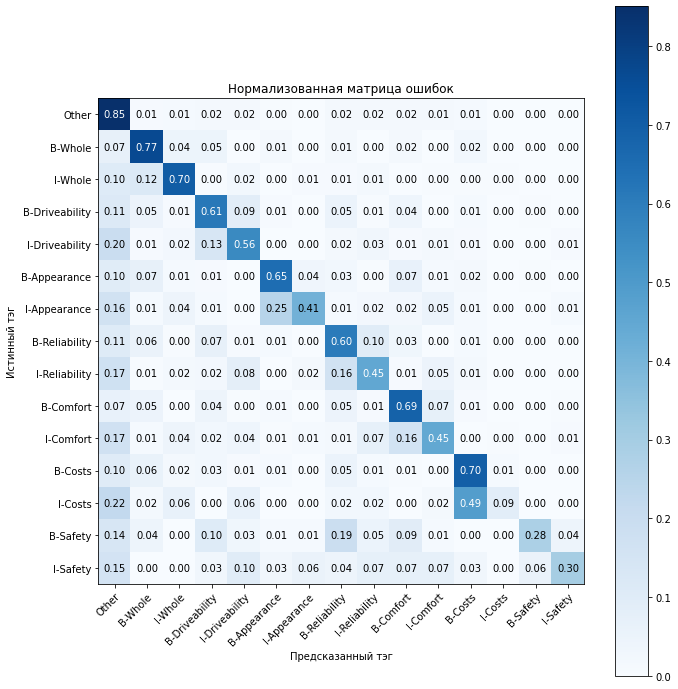

In [66]:
#hyperparameters
exp_name = 'epoch_n=40_rnn_num_layers=3_dropout_rnn=0.4_hidden_size=128_weights=only_other_30'
hyps = {
    
    #Model
    'emb_size': 300,
    'hidden_size': 120,
    'RNN_class': nn.LSTM, #nn.GRU, or nn.LSTM
    'rnn_num_layers': 3,
    'dropout_rnn': 0.4, #applied only if rnn_num_layer > 1
    
    #loss
    'class_weights': 'only_other_30', #'nunique_tokens', 'log_nunique_tokens', 'only_other_10', 
                                       #'only_other_30', 'only_other_100', 'no_weights'
    
    #optim
    'optim_class': optim.SGD, #optim.SGD, optim.Adam
    'lr': 0.1,
    'epoch_n': 40,
    'batch': None,
    
    #train_loop
    'best_loss_model': False
}

histories[exp_name] = {
    'hyps': hyps
}

TAGSET_SIZE   = len(tag_converter.tag_to_idx)

########## class_weights #############

from collections import Counter
from pprint import pprint
from math import e

if hyps['class_weights'] == 'nunique_tokens' or hyps['class_weights'] == 'log_nunique_tokens':
    tag_counter = Counter()
    for label in labels:
        tag_counter[label] = len(word_counter[label])

    #pprint(tag_counter.most_common())


    class_weights = torch.ones(15)
    class_divs    = torch.ones(15)

    for tag, inv_weight in tag_counter.most_common():
        tag_idx             = tag_converter.tags_to_index([tag])
        class_divs[tag_idx] = inv_weight

    norm       = torch.norm(class_divs, p=2, dim=0).detach()
    class_divs = class_divs.div(norm.expand_as(class_divs))

    class_weights /= class_divs
    
    if hyps['class_weights'] == 'log_nunique_tokens':
        class_weights = (class_weights * e).log()

elif hyps['class_weights'] == 'only_other_10':
    class_weights = torch.ones(15) * 10
    class_weights[-1] = 1.
    
elif hyps['class_weights'] == 'only_other_30':
    class_weights = torch.ones(15) * 30
    class_weights[-1] = 1.

elif hyps['class_weights'] == 'only_other_100':
    class_weights = torch.ones(15) * 100
    class_weights[-1] = 1.
    
elif hyps['class_weights'] == 'no_weights':
    class_weights = torch.ones(15)

#print(class_weights.detach())


######## Train model #########

if 'model' in locals():
    del best_model #for freeze memory
model         = LSTMTagger(hyps['emb_size'], hyps['hidden_size'], TAGSET_SIZE, word_converter,
                           num_layers = hyps['rnn_num_layers'], dropout_rnn = hyps['dropout_rnn'], RNN_class = hyps['RNN_class'])
loss_function = nn.NLLLoss(class_weights)
optimizer     = hyps['optim_class'](model.parameters(), lr=hyps['lr'])

# import psutil
# print(f"Check 01 - {psutil.virtual_memory()[2]}%")

# from livelossplot import PlotLosses

# liveplot = PlotLosses()

#statistics history
history = {'acc': {'train': [0.0],
                    'val': [0.0]},
           'acc_no_other': {'train': [0.0],
                            'val': [0.0]},
           'loss': {'train': [float('inf')],
                    'val': [float('inf')]}}
train_start_time = datetime.datetime.now()

#отбираем лучшую модель по максимальному accuracy
best_val_metric = float('-inf')   
best_epoch_i = 0
# print(f"Check 01 - {psutil.virtual_memory()[2]}%")
if 'best_model' in locals():
    del best_model #for freeze memory
best_model = copy.deepcopy(model)
# print(f"Check 02 - {psutil.virtual_memory()[2]}%")

for epoch in range(hyps['epoch_n']):
#     print(f"Check 03 - {psutil.virtual_memory()[2]}%")
    ########starting of epoch#########
    epoch_start = datetime.datetime.now()
    model.train()
    
    for i, (sentence, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
        tag_ground    = tag_converter.tags_to_index(tags) 
        
        
        loss = loss_function(tag_predicted, tag_ground)
        loss.backward()
        optimizer.step()
        
#         if i % 100 == 0:
#             liveplot.update({'negative log likelihood loss': loss.detach().numpy()})
#             liveplot.draw()
    
    ########ending of epoch#########
#     print(f"Check 04 - {psutil.virtual_memory()[2]}%")
    model.eval()
    with torch.no_grad():
        #save current epoch Train Statistics
        y_pred = []
        y_true = []
        loss_epoch = []
        for sentence, tags in training_data:
            #accuracy
            y_pred += predict_tags(model, sentence)
            y_true += tags

            #loss
            tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
            tag_ground    = tag_converter.tags_to_index(tags) 
            loss_epoch.append(loss_function(tag_predicted, tag_ground).detach().numpy())

        history['acc']['train'].append(sum(np.array(y_pred) == np.array(y_true))/len(y_pred))
        y_pred_wo_label, y_true_wo_label = get_without_label(y_pred, y_true, label='Other')
        history['acc_no_other']['train'].append(sum(np.array(y_pred_wo_label) == np.array(y_true_wo_label))/len(y_pred_wo_label))
        history['loss']['train'].append(np.array(loss_epoch).mean())
#         print(f"Check 05 - {psutil.virtual_memory()[2]}%")
        #save current epoch Val Statistics
        y_pred = []
        y_true = []
        loss_epoch = []
        for sentence, tags in test_data:
            #accuracy
            y_pred += predict_tags(model, sentence)
            y_true += tags

            #loss
            tag_predicted = model(sentence) # <- теперь передаем предложение, а не список индексов слов
            tag_ground    = tag_converter.tags_to_index(tags) 
            loss_epoch.append(loss_function(tag_predicted, tag_ground).detach().numpy())

        history['acc']['val'].append(sum(np.array(y_pred) == np.array(y_true))/len(y_pred))
        y_pred_wo_label, y_true_wo_label = get_without_label(y_pred, y_true, label='Other')
        history['acc_no_other']['val'].append(sum(np.array(y_pred_wo_label) == np.array(y_true_wo_label))/len(y_pred_wo_label))
        history['loss']['val'].append(np.array(loss_epoch).mean())
#         print(f"Check 06 - {psutil.virtual_memory()[2]}%")
    #save best model
#     print(f"Check 07 - {psutil.virtual_memory()[2]}%")
    best_model_saved = False
    if history['acc_no_other']['val'][-1] > best_val_metric:
                #отбираем модель по максимальному accuracy_no_other
                best_epoch_i = epoch
                best_val_metric = history['acc_no_other']['val'][-1]
                del best_model
#                 print(f"Check 08 - {psutil.virtual_memory()[2]}%")
                best_model = copy.deepcopy(model)
                best_model_saved = True
#     print(f"Check 09 - {psutil.virtual_memory()[2]}%")
    #output statistics
    print('Epoch={:>2}, ACC: val = {:.4f}/{:.4f}, trn = {:.4f}/{:.4f} LOSS: val = {:.4f}, trn = {:.4f}, diff = {:.4f} SAVE: {}, It: {}, T: {:0.2f}s'\
                  .format(epoch,
                          history['acc']['val'][-1], 
                          history['acc_no_other']['val'][-1],
                          history['acc']['train'][-1],
                          history['acc_no_other']['train'][-1],
                          history['loss']['val'][-1],
                          history['loss']['train'][-1],
                          history['loss']['val'][-1] - history['loss']['train'][-1],
                          best_model_saved,
                          i,
                          (datetime.datetime.now() - epoch_start).total_seconds()),
                  flush=True)

histories[exp_name] = {
    'history': history,
    'best_epoch_i': best_epoch_i,
    'full_train_time': (datetime.datetime.now() - train_start_time).total_seconds()
}

print()
print("BEST MODEL: ACC: val = {:.4f}/{:.4f}, train = {:.4f}/{:.4f}, LOSS: val = {:.4f}, train = {:.4f}, on epoch = {}, Full train time = {:0.2f}s"\
                  .format(history['acc']['val'][best_epoch_i], 
                          history['acc_no_other']['val'][best_epoch_i], 
                          history['acc']['train'][best_epoch_i],
                          history['acc_no_other']['train'][best_epoch_i],
                          history['loss']['val'][best_epoch_i],
                          history['loss']['train'][best_epoch_i],
                          best_epoch_i,
                          (datetime.datetime.now() - train_start_time).total_seconds()))

#Проверка работы на новом, не входящем в train/test комментарии (в том числе с новыми токенами)
custom_sentence = word_tokenizer.tokenize(
    'Ходовые характеристики хорошие, разгон набирает уверенно, а вот внешний вид мне не очень нравится. \
      Кондиционер охлаждает прямо очень быстро. В целом машина норм.')
try:
    tags_pred    = predict_tags(best_model, custom_sentence)

    print('предсказанные тэги:')
    text, spans = generate_markup(custom_sentence, tags_pred)

    show_markup(text, spans)
    print()
except Exception as ex:
    print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))

y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(best_model, sentence)
    y_true += tags

plot_confusion_matrix(y_true, y_pred, classes=ordered_tags, normalize=True,
                      title='Нормализованная матрица ошибок')
plt.show()

### Итоги экспериментов

In [67]:
for exp_name, exp in histories.items():
    print('{:-<100}'.format(exp_name))
    best_epoch_i = exp['best_epoch_i']
    history = exp['history']
    print("BEST MODEL: ACC: val = {:.4f}/{:.4f}, train = {:.4f}/{:.4f}, LOSS: val = {:.4f}, train = {:.4f}, on epoch = {}, Full train time = {:0.2f}s"\
                  .format(history['acc']['val'][best_epoch_i], 
                          history['acc_no_other']['val'][best_epoch_i], 
                          history['acc']['train'][best_epoch_i],
                          history['acc_no_other']['train'][best_epoch_i],
                          history['loss']['val'][best_epoch_i],
                          history['loss']['train'][best_epoch_i],
                          best_epoch_i,
                          exp['full_train_time']))
    print()

baseline_7.1----------------------------------------------------------------------------------------
BEST MODEL: ACC: val = 0.7876/0.4794, train = 0.8510/0.7003, LOSS: val = 1.2624, train = 0.5356, on epoch = 4, Full train time = 213.10s

epoch_n=30_rnn_num_layers=3_dropout_rnn=0.2_hidden_size=128_weights=only_other_30-------------------
BEST MODEL: ACC: val = 0.8023/0.5797, train = 0.8957/0.9476, LOSS: val = 1.6253, train = 0.0999, on epoch = 12, Full train time = 2916.69s

epoch_n=30_rnn_num_layers=3_dropout_rnn=0.2_hidden_size=128_weights=only_other_100------------------
BEST MODEL: ACC: val = 0.6783/0.5974, train = 0.7073/0.8129, LOSS: val = 1.2083, train = 0.3488, on epoch = 5, Full train time = 2918.88s

epoch_n=30_rnn_num_layers=6_dropout_rnn=0.2_hidden_size=128_weights=only_other_30-------------------
BEST MODEL: ACC: val = 0.8059/0.5494, train = 0.9108/0.9498, LOSS: val = 1.7606, train = 0.1018, on epoch = 27, Full train time = 5478.49s

epoch_n=30_rnn_num_layers=3_dropout_rnn

In [68]:
!rm -rf stepik-dl-nlp
!ls

__notebook__.ipynb
